### TDA analytics

In [1]:
import pandas as pd
from transformers import (
    AutoTokenizer,
    BertForMaskedLM,
    BertConfig,
    DataCollatorForLanguageModeling,
    DefaultDataCollator,
    default_data_collator,
    TrainingArguments,
    Trainer
)
import pickle
from transformers.modeling_outputs import MaskedLMOutput
# from google.colab import drive
import torch
from typing import Optional
from torch import nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from datasets import load_metric
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import math
from tqdm.notebook import tqdm

import pathlib
import pickle

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
SEQ_LEN = 64
BATCH_SIZE = 50
HID_SIZE = 768
DROPOUT = 0.15

In [4]:
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

from MinioHandler import MinioHandler

In [5]:
import gc
def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

In [6]:
minio = MinioHandler()

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True

In [8]:
VOCAB_SIZE = tokenizer.vocab_size

### Models

In [10]:
bert_model = BertForMaskedLM.from_pretrained(MODEL_NAME)

In [11]:
from dataclasses import dataclass, field

@dataclass(kw_only=True)
class GramMaskedLMOutput(MaskedLMOutput):
    gram_output: Optional[torch.tensor] = field(default=None,)
    proj_output: Optional[torch.tensor] = field(default=None,)
    last_hidden_state: Optional[torch.tensor] = field(default=None,)


class BertModule(nn.Module):
    def __init__(self, model):
        super(BertModule, self).__init__()
        self.bert = model

    def forward(self, input_ids, attention_mask, token_type_ids, *args, **kwargs):
        output = self.bert(input_ids=input_ids,
               attention_mask=attention_mask,
               token_type_ids=token_type_ids,
               **kwargs
              )
        return output

class GramModule(nn.Module):
    def __init__(self, hidden_size = HID_SIZE, dropout = DROPOUT, num_layers = 1, flag=True):
        super(GramModule, self).__init__()
        self.LSTM = nn.LSTM(hidden_size + flag, hidden_size, num_layers)
    def forward(self, X, poly_flag):
        emb_with_poly_flag = torch.cat([X, poly_flag.unsqueeze(1).repeat(1, SEQ_LEN).unsqueeze(2)], dim=2)
        output, _ = self.LSTM(emb_with_poly_flag)
        return output


class MLMHead(nn.Module):
    def __init__(self, vocab_size = VOCAB_SIZE, hidden_size = HID_SIZE, dropout = DROPOUT, flag=False):
        super(MLMHead, self).__init__()
        self.linear_stack = nn.Sequential(
        nn.Linear(hidden_size+flag, hidden_size),
        nn.GELU(),
        nn.LayerNorm((768,), eps=1e-12)
        )
        self.emb_matrix = nn.Linear(hidden_size, vocab_size)
        self.flag=flag

    def forward(self, X, poly_flag=None, *args, **kwargs):
        if self.flag:
            X = torch.cat([X, poly_flag.unsqueeze(1).repeat(1, SEQ_LEN).unsqueeze(2)], dim=2)
        linear_output = self.linear_stack(X)
        logits = self.emb_matrix(linear_output)
        return logits, linear_output


class ModularLM(nn.Module):
    def __init__(self,):
        super(ModularLM, self).__init__()
        self.bert_module = BertModule(model=bert_model.bert)
        self.head = MLMHead(flag=True)
        self.head.emb_matrix.weight = self.bert_module.bert.embeddings.word_embeddings.weight

    def forward(self, input_ids, attention_mask, poly_flag, token_type_ids=None, **kwargs):
        bert_output = self.bert_module(input_ids=input_ids, 
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
    
        output, proj_output = self.head(bert_output.last_hidden_state, poly_flag)
        return GramMaskedLMOutput(
            loss=None,
            logits=output,
            hidden_states=bert_output.hidden_states,
            attentions=bert_output.attentions,
            last_hidden_state=bert_output.last_hidden_state,
            gram_output=None,
            proj_output=proj_output
            )

class ModularLSTMLM(nn.Module):
    def __init__(self):
        super(ModularLSTMLM, self).__init__()
        self.bert_module = BertModule(model=bert_model.bert)
        self.gram = GramModule(flag=True)
        self.head = MLMHead(flag=False)
        self.head.emb_matrix.weight = self.bert_module.bert.embeddings.word_embeddings.weight

    def forward(self, input_ids, attention_mask, poly_flag, token_type_ids=None, **kwargs):
        bert_output = self.bert_module(input_ids=input_ids, 
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        gram_output = self.gram(X=bert_output.last_hidden_state, 
                        poly_flag=poly_flag)
        output, proj_output = self.head(gram_output)
        return GramMaskedLMOutput(
            loss=None,
            logits=output,
            hidden_states=bert_output.hidden_states,
            attentions=bert_output.attentions,
            last_hidden_state=bert_output.last_hidden_state,
            proj_output=proj_output,
            gram_output=gram_output
                                )

ModularLM.device = device
ModularLSTMLM.device = device

### Data

In [9]:
df_test = pd.read_csv("../data/test_dataset.csv", index_col=0)
df_test_pref = pd.read_csv("../data/test_dataset_prefix.csv", index_col=0)

In [10]:
df = df_test.sample(1000, random_state=42, ignore_index=True)
df_pref = df_test_pref.sample(1000, random_state=42, ignore_index=True)

In [11]:
del df_test, df_test_pref

In [12]:
df.head(5)

,base,polypers,was_changed
0,"Она , оказывается , слышала каждое слово .","Она , оказывается , слышалает каждое слово .",True
1,"— Провались они , такие межпланетные контакты ...","— Провались они , такие межпланетные контакты ...",False
2,"— Ладно-ладно , — захныкал Рыж .","— Ладно-ладно , — захныкал Рыж .",False
3,"Он выстриг у Вихря шерсть вокруг болячек , чем...","Он выстригет у Вихря шерсть вокруг болячек , ч...",True
4,Борис судорожно глотнул и тоже неестественным ...,Борис судорожно глотнул и тоже неестественным ...,False


In [13]:
df_pref.head(5)

,base,polypers,was_changed
0,"Она , оказывается , слышала каждое слово .","Она , оказывается , етслышала каждое слово .",True
1,"— Провались они , такие межпланетные контакты ...","— Провались они , такие межпланетные контакты ...",False
2,"— Ладно-ладно , — захныкал Рыж .","— Ладно-ладно , — захныкал Рыж .",False
3,"Он выстриг у Вихря шерсть вокруг болячек , чем...","Он етвыстриг у Вихря шерсть вокруг болячек , ч...",True
4,Борис судорожно глотнул и тоже неестественным ...,Борис судорожно глотнул и тоже неестественным ...,False


In [14]:
from PairsDataset import PairsDataset

dataset = PairsDataset(tokenizer, data=df, filter_same=False, SEQ_LEN=SEQ_LEN, return_tensors="pt")
dataset_pref = PairsDataset(tokenizer, data=df_pref, filter_same=False, SEQ_LEN=SEQ_LEN, return_tensors="pt")

In [15]:
default_data_collator = DefaultDataCollator()

def collate_func(batch):
    data = [{k: v.squeeze() for k, v in default_data_collator(item).items()} for item in zip(*batch)]
    return data

In [16]:
dl = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_func)
dl_pref = torch.utils.data.DataLoader(dataset_pref, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_func)

In [17]:
import gudhi as gh
import gudhi.representations.metrics as ghd
import ripser
from collections import namedtuple
import seaborn as sns

In [18]:
import warnings

In [19]:
warnings.filterwarnings("ignore")

In [20]:
from functools import reduce 
import operator

def get_by_path(root, items):
    """Access a nested object in root by item sequence."""
    return reduce(operator.getitem, items, root)

def set_by_path(root, items, value):
    """Set a value in a nested object in root by item sequence."""
    get_by_path(root, items[:-1])[items[-1]] = value

In [21]:
import seaborn as sns

In [22]:
from sklearn.pipeline import Pipeline

In [23]:
pipe_ent = Pipeline([
    ("picker", gh.representations.DiagramSelector(use=True)), 
    ("selector", gh.representations.ProminentPoints(use=True, num_pts=15, threshold=.2)),
    ("ent", gh.representations.Entropy()),
])

In [24]:
pipe_avg = Pipeline([
    ("picker", gh.representations.DiagramSelector(use=True)), 
    ("selector", gh.representations.ProminentPoints(use=True, num_pts=15, threshold=.2)),
])

In [25]:
vr = ripser.Rips(maxdim=1,)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [28]:
from collections import defaultdict

def collect_tda_stats_layerwise(model, dl, poly_type: str):
    
    def stats_from_layer(outputs):

        splitted = outputs.split(1)

        zero, one = zip(*[vr.fit_transform(elem.squeeze().numpy()) for elem in splitted])
        
        zero_ent = pipe_ent.fit_transform([*zero]).squeeze()
        one_ent = pipe_ent.fit_transform([*one]).squeeze()
        
        zero_len = [np.mean([(b-a) for a,b in item]) for item in pipe_avg.transform([*zero])]
        one_len = [np.mean([(b-a) for a,b in item]) for item in pipe_avg.transform([*one])]

        return {"zero": zero, "one": one, "zero_ent": zero_ent, "one_ent": one_ent, "zero_len": zero_len, "one_len": one_len}

    def stats_for_lang(batch_lang, lang: str):

        nonlocal tda_stats
        
        with torch.no_grad():
            output = model(**batch_lang, output_hidden_states=True)

        for i, layer in enumerate(output.hidden_states):
            layer = layer.cpu()
            out = stats_from_layer(layer)
            for k, v in out.items():
                tda_stats[f"{lang}_layer_{i}_{k}"].extend(v)

        layer = output.proj_output.cpu()
        out = stats_from_layer(layer)
        for k, v in out.items():
            tda_stats[f"{lang}_proj_{k}"].extend(v)

        if type(model) is ModularLSTMLM:
            layer = output.gram_output.cpu()
            out = stats_from_layer(layer)
            for k, v in out.items():
                tda_stats[f"{lang}_gram_{k}"].extend(v)
        return None
    
    model.eval()
    tda_stats = defaultdict(list)
    
    for base, poly in tqdm(dl):

        flag=0

        base["poly_flag"] = torch.tensor([flag]*BATCH_SIZE)
        poly["poly_flag"] = torch.tensor([(flag+1)%2]*BATCH_SIZE)

        base, poly = ({k: v.to(device) for k, v in item.items()} for item in (base, poly))
        
        stats_for_lang(base, "base")
        stats_for_lang(poly, poly_type)

    return tda_stats

In [66]:
model_list = [["modular_lm_4.1_mix_flag_full_100k.pt",
                "modular_lm_4.1_prefix_mix_flag_full_100k.pt"],
                ["modular_lm_4.2.1_mix_flag_full_100k.pt",
                "modular_lm_4.2.1_prefix_mix_flag_full_100k.pt"]]

In [56]:
mapper_model = {0: ModularLM,
                1: ModularLSTMLM}

mapper_dl = {0: dl,
             1: dl_pref}

mapper_lang_type = {0: "suff",
                    1: "pref"}

In [76]:
for i, _ in enumerate(model_list):
    for j, _ in enumerate(model_list[i]):

        model = mapper_model[i]().to(device)
        ckpt = minio.get_object(object_name=f"ckpt/trained_models/gram_module/{model_list[i][j]}", type="model")
        weights = torch.load(ckpt, map_location="cpu")["model_state_dict"]
        model.load_state_dict(weights)

        stats = collect_tda_stats_layerwise(model, mapper_dl[j], poly_type=mapper_lang_type[j])
        with open(f"../logs/trained_models/{model_list[i][j][:-3]}.stats", "wb") as f:
            pickle.dump(stats, f)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
with open("../logs/trained_models/modular_lm_4.1_mix_flag_full_100k.stats", "rb") as f:
    stats = pickle.load(f)

In [33]:
stats.keys()

dict_keys(['base_layer_0_zero', 'base_layer_0_one', 'base_layer_0_zero_ent', 'base_layer_0_one_ent', 'base_layer_0_zero_len', 'base_layer_0_one_len', 'base_layer_1_zero', 'base_layer_1_one', 'base_layer_1_zero_ent', 'base_layer_1_one_ent', 'base_layer_1_zero_len', 'base_layer_1_one_len', 'base_layer_2_zero', 'base_layer_2_one', 'base_layer_2_zero_ent', 'base_layer_2_one_ent', 'base_layer_2_zero_len', 'base_layer_2_one_len', 'base_layer_3_zero', 'base_layer_3_one', 'base_layer_3_zero_ent', 'base_layer_3_one_ent', 'base_layer_3_zero_len', 'base_layer_3_one_len', 'base_layer_4_zero', 'base_layer_4_one', 'base_layer_4_zero_ent', 'base_layer_4_one_ent', 'base_layer_4_zero_len', 'base_layer_4_one_len', 'base_layer_5_zero', 'base_layer_5_one', 'base_layer_5_zero_ent', 'base_layer_5_one_ent', 'base_layer_5_zero_len', 'base_layer_5_one_len', 'base_layer_6_zero', 'base_layer_6_one', 'base_layer_6_zero_ent', 'base_layer_6_one_ent', 'base_layer_6_zero_len', 'base_layer_6_one_len', 'base_layer_7_ze

In [106]:
base_selection = {k: v for k,v in stats.items() if not k.endswith(("len", "ent")) and k.startswith("suff")}

In [107]:
zero_selection = {k: v for k,v in base_selection.items() if k.endswith("zero")}

In [108]:
one_selection = {k: v for k,v in base_selection.items() if k.endswith("one")}

In [99]:
def compute_distances(diagrams, dict_zero_keys, dict_one_keys, estimator=ghd.BottleneckDistance(n_jobs=10)):

    zero, one = diagrams

    dist = estimator.fit_transform([*zero])
    model_diff_zero = pd.DataFrame(dist, index=dict_zero_keys, columns=dict_zero_keys)
    
    dist = estimator.fit_transform([*one])
    model_diff_one = pd.DataFrame(dist, index=dict_one_keys, columns=dict_one_keys)

    return model_diff_zero, model_diff_one

In [100]:
def compute_distances_v2(diagrams, dict_zero_keys, dict_one_keys, estimator=ghd.BottleneckDistance(n_jobs=10)):

    zero, one = diagrams

    zero, one = pipe_avg.transform([*zero]), pipe_avg.transform([*one])

    dist = estimator.fit_transform([*zero])
    model_diff_zero = pd.DataFrame(dist, index=dict_zero_keys, columns=dict_zero_keys)
    
    dist = estimator.fit_transform([*one])
    model_diff_one = pd.DataFrame(dist, index=dict_one_keys, columns=dict_one_keys)

    return model_diff_zero, model_diff_one

In [61]:
est = ghd.WassersteinDistance(order=2, n_jobs=10)

In [110]:
zero_dists, one_dists = [], []
for i in tqdm(range(1000)):

    zeros, ones = [], []
    
    for v in zero_selection.values():
        zeros.append(v[i])
    
    for v in one_selection.values():
        ones.append(v[i])
    
    #zero_dist, one_dist = compute_distances((zeros, ones), zero_selection.keys(), one_selection.keys(),)
    zero_dist, one_dist = compute_distances_v2((zeros, ones), zero_selection.keys(), one_selection.keys(), estimator=est)
    zero_dists.append(zero_dist)
    one_dists.append(one_dist)

df_dist = pd.DataFrame({
    "distance_zero": zero_dists,
    "distance_one": one_dists,
    "was_changed": df.was_changed
                  },)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [57]:
def plot_bottleneck_dist(df, model_name):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10), )
    dfs = df[df.was_changed].distance_zero.to_numpy()

    model_x, model_y = dfs[0].shape
    
    df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
    df_mean = dfs.mean().to_numpy()
    char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(model_x)] for j in range(model_y)]
    matrix = np.triu(df_mean, 1)
    sns.heatmap(df[df.was_changed].distance_zero.to_numpy().mean(), ax=ax[0], annot=char_df, fmt="", annot_kws={"fontsize":7}, mask=matrix)
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=80)
    ax[0].set_title("$H_0$ bottleneck dist")
    
    dfs = df[df.was_changed].distance_one.to_numpy()
    df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
    df_mean = dfs.mean().to_numpy()
    char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(model_x)] for j in range(model_y)]
    matrix = np.triu(df_mean, 1)
    sns.heatmap(df[df.was_changed].distance_one.to_numpy().mean(), ax=ax[1], annot=char_df, fmt="", annot_kws={"fontsize":7}, mask=matrix)
    ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=80)
    ax[1].set_title("$H_1$ bottleneck dist")
    
    
    plt.suptitle(model_name, fontweight="bold", y=.92)

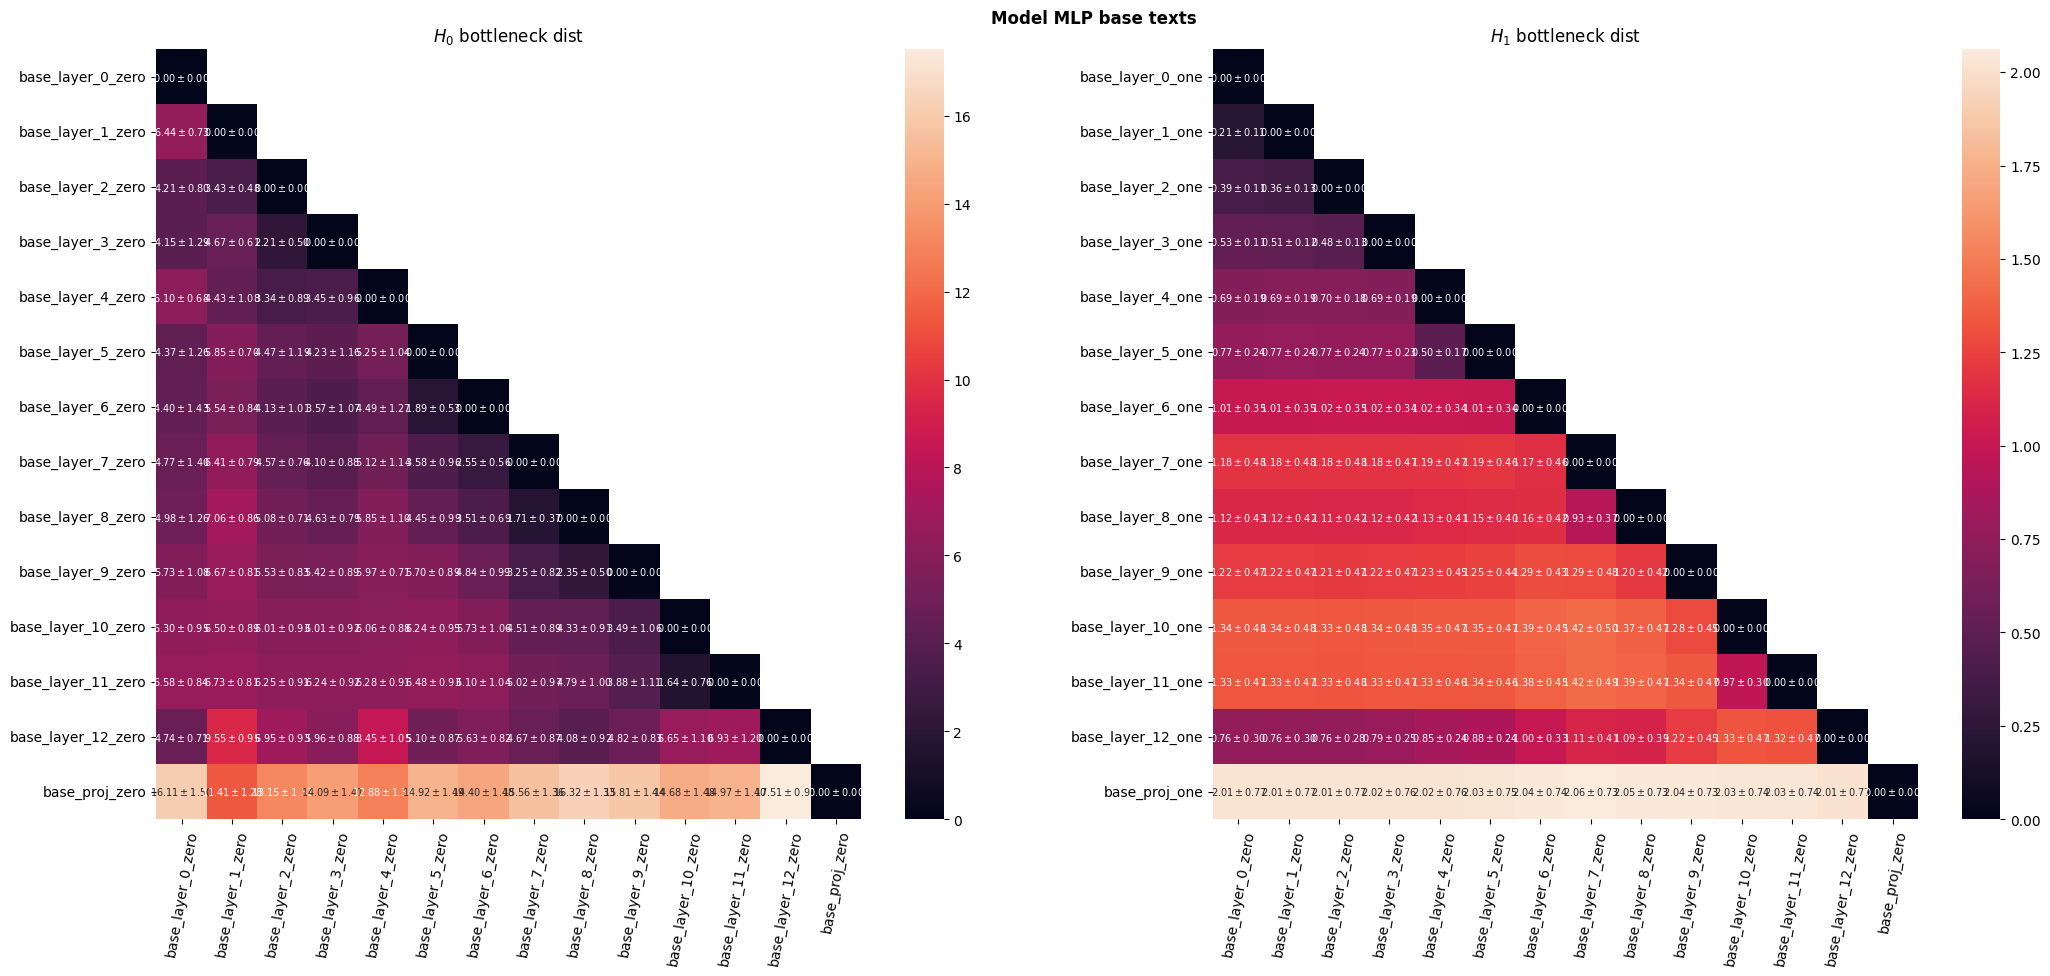

In [59]:
plot_bottleneck_dist(df_dist, "Model MLP base texts")

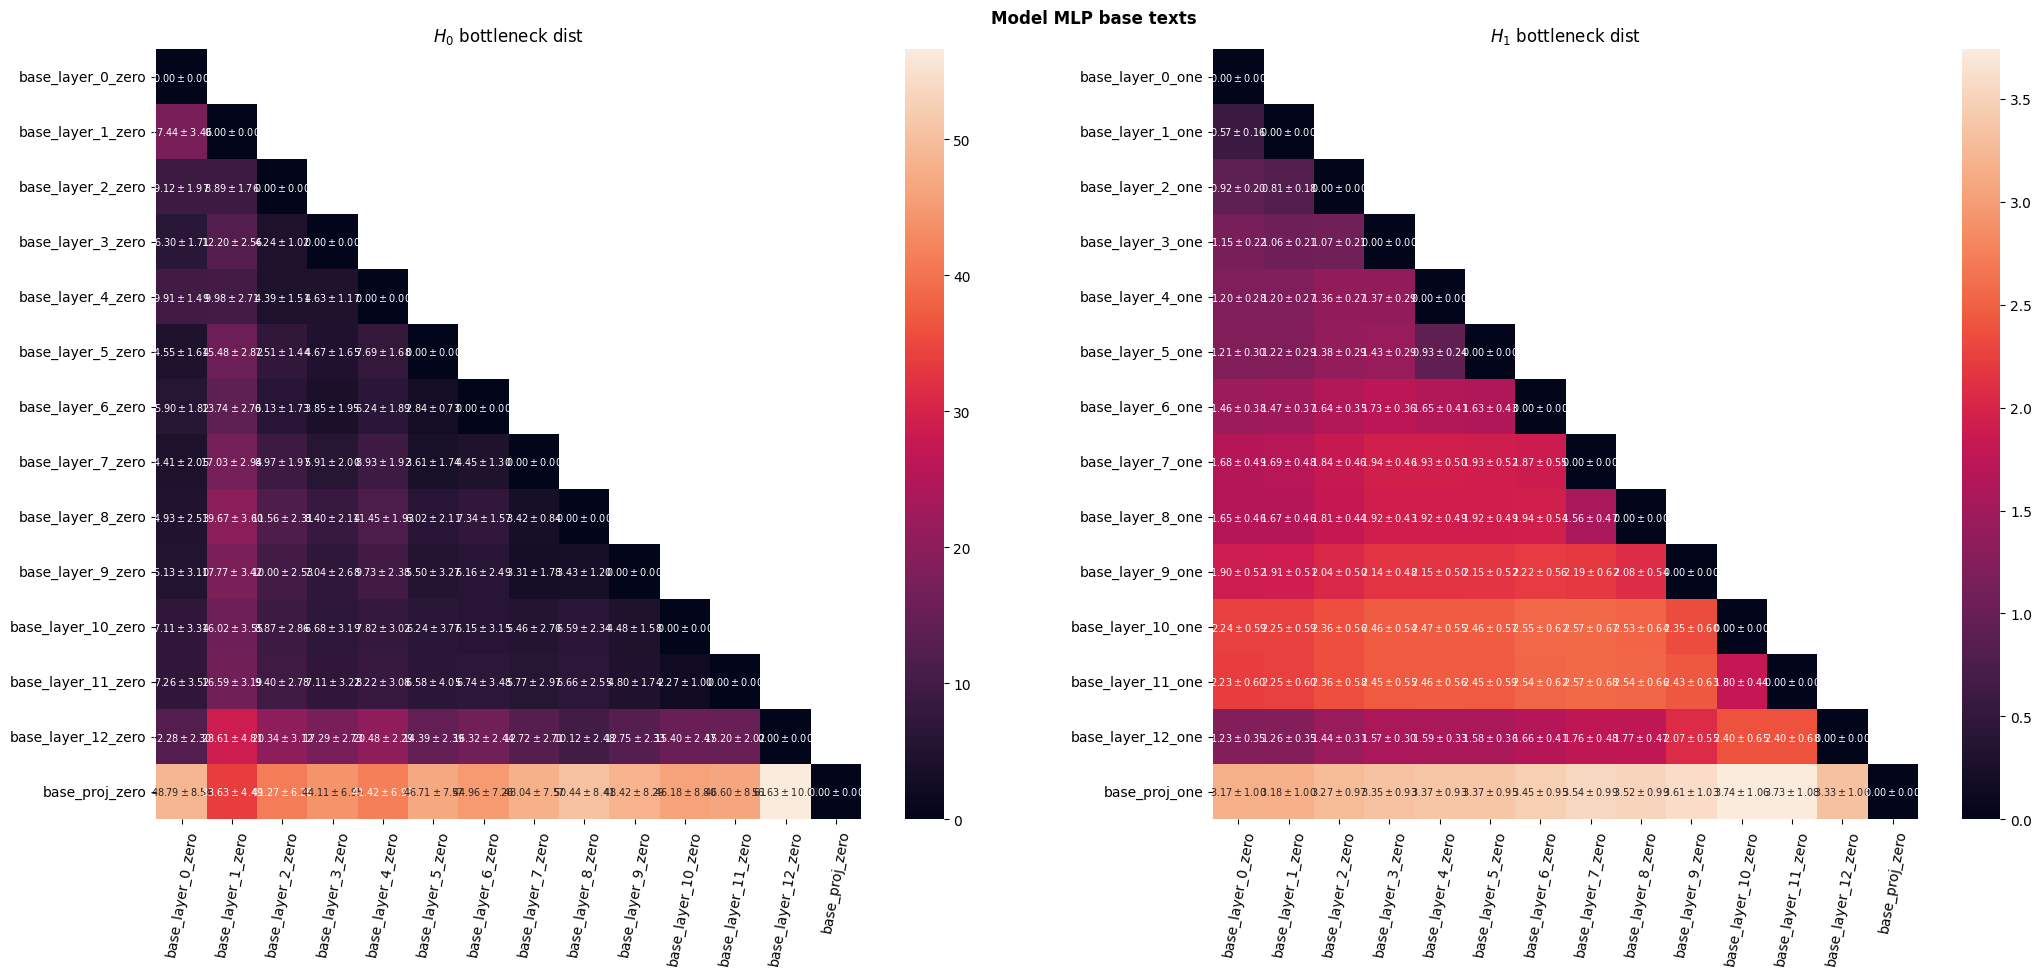

In [105]:
plot_bottleneck_dist(df_dist, "Model MLP base texts")

In [ ]:
plot_bottleneck_dist(df_dist, "Model MLP suff texts, Bottleneck metric")

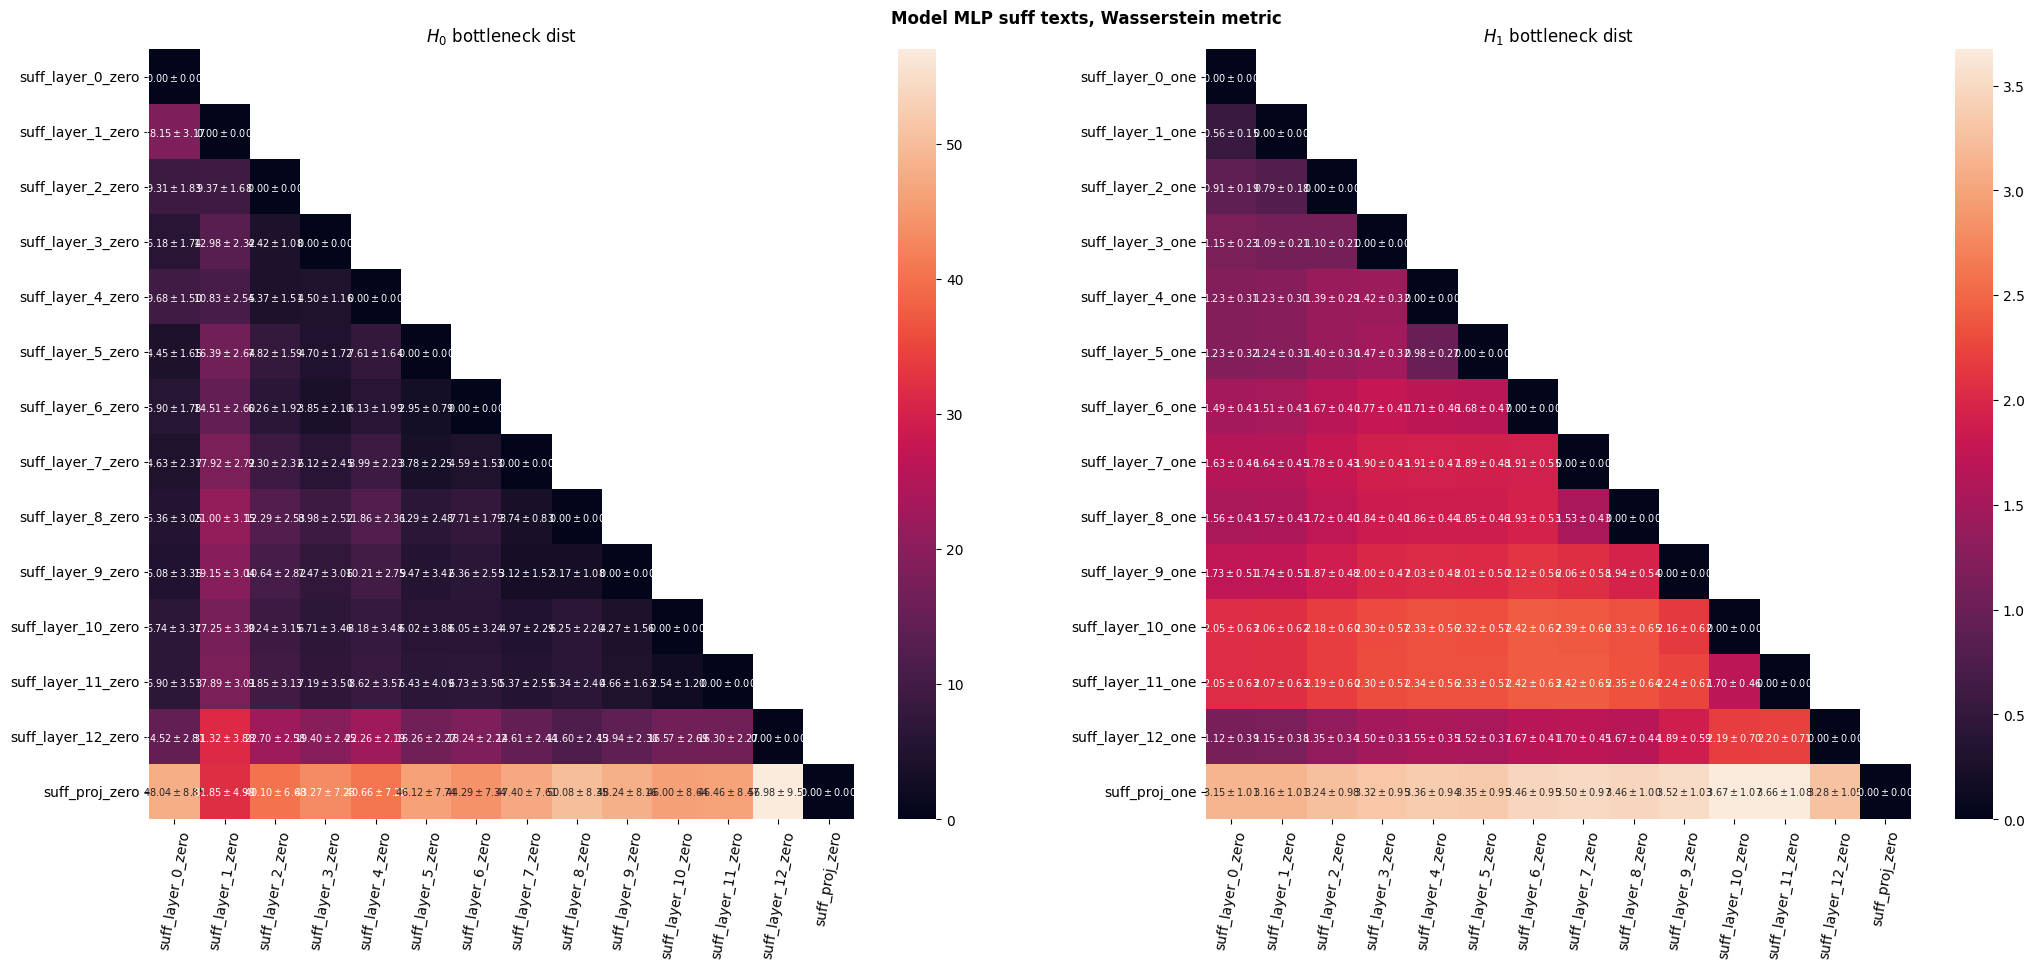

In [111]:
plot_bottleneck_dist(df_dist, "Model MLP suff texts, Wasserstein metric")

Text(0.5, 1.0, 'H_1 bottleneck dist')

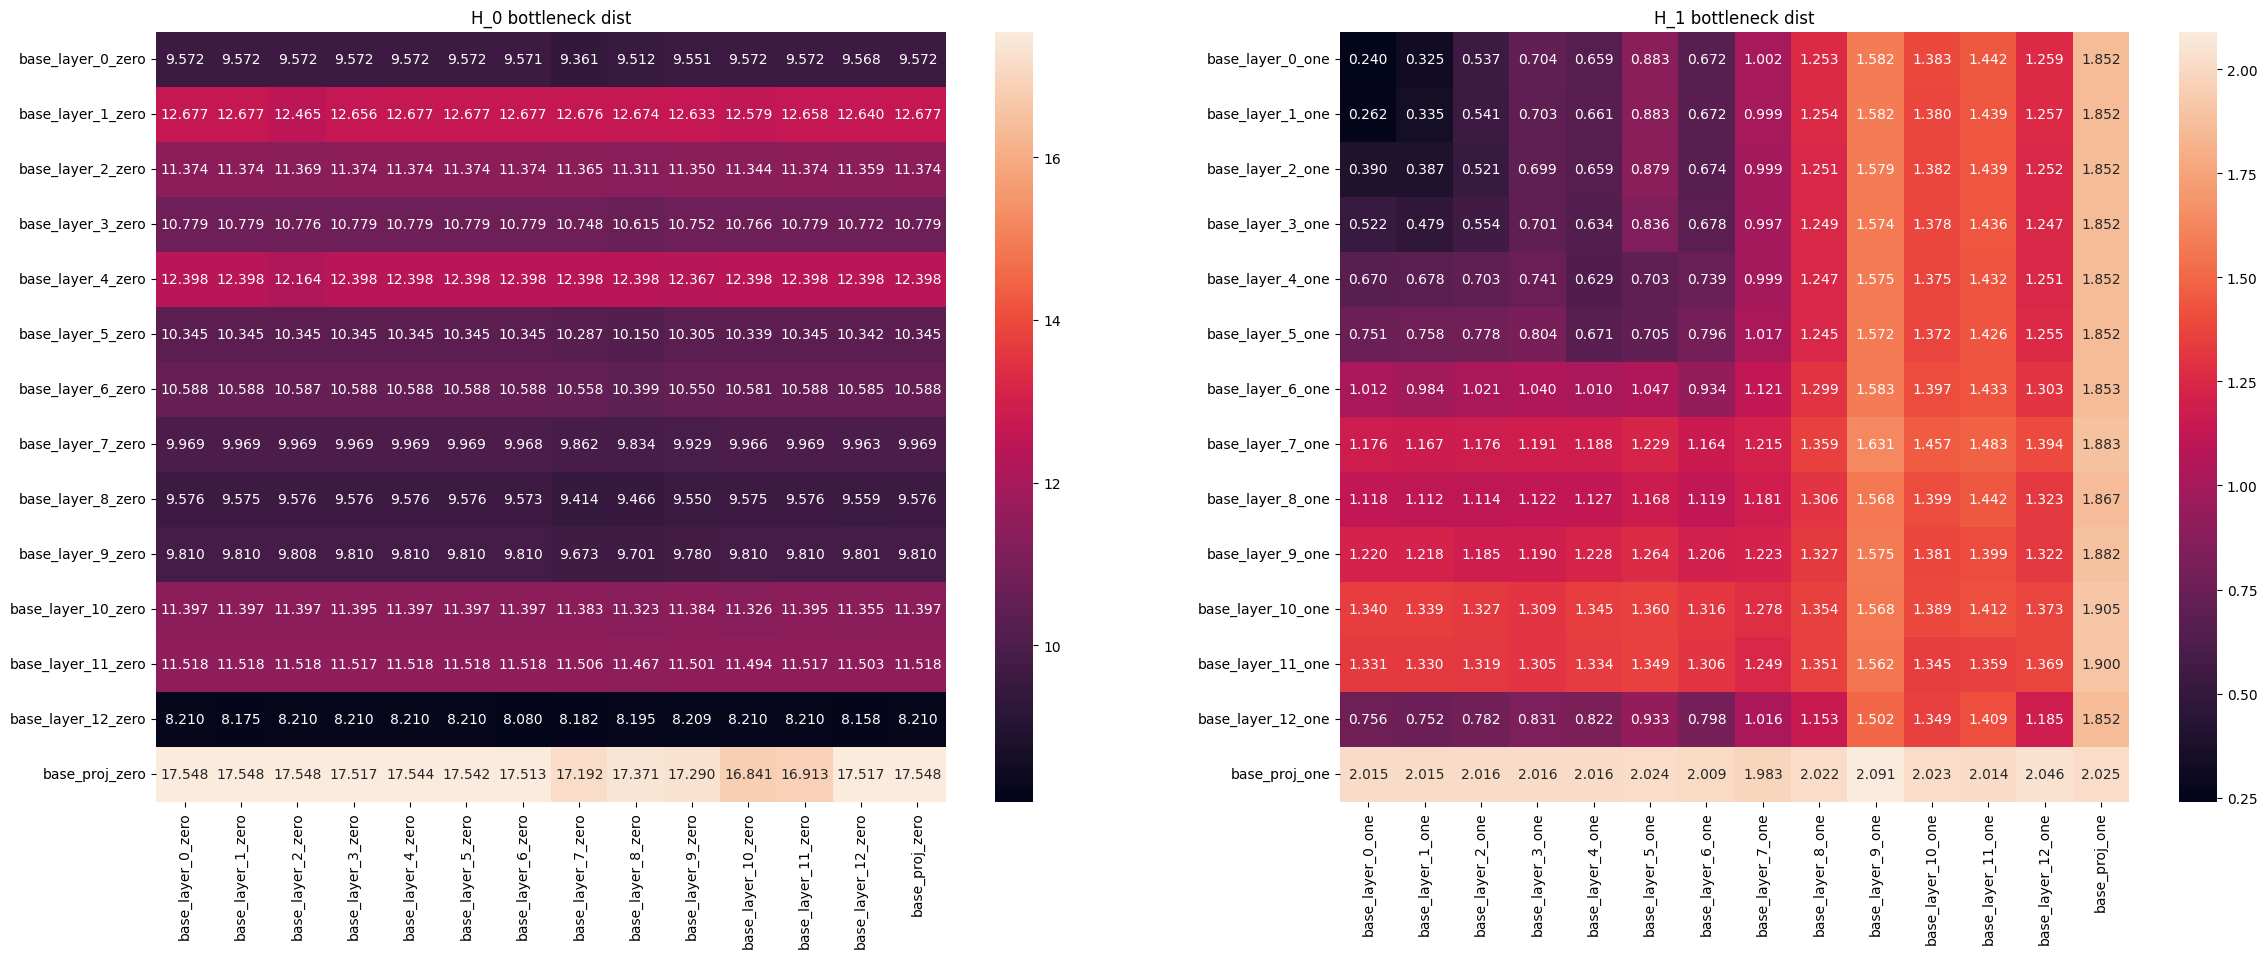

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(28, 10), )
sns.heatmap(df_dist[df.was_changed].distance_zero.to_numpy().mean(), ax=ax[0], annot=True, fmt=".3f")
ax[0].set_title("H_0 bottleneck dist")
sns.heatmap(df_dist[df.was_changed].distance_one.to_numpy().mean(), ax=ax[1], annot=True, fmt=".3f")
ax[1].set_title("H_1 bottleneck dist")

In [201]:
columns = ["_".join([item, char, dim]) for dim in ("zero", "one") for char in ("len", "entropy") for item in sentence_repr._fields] + ["distance_zero", "distance_one",]

In [302]:
dfs = df[df.was_changed].distance_zero.to_numpy()

In [340]:
df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
df_mean = dfs.mean().to_numpy()

In [378]:
char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(11)] for j in range(11)]

Text(0.5, 0.98, '4.1_100k')

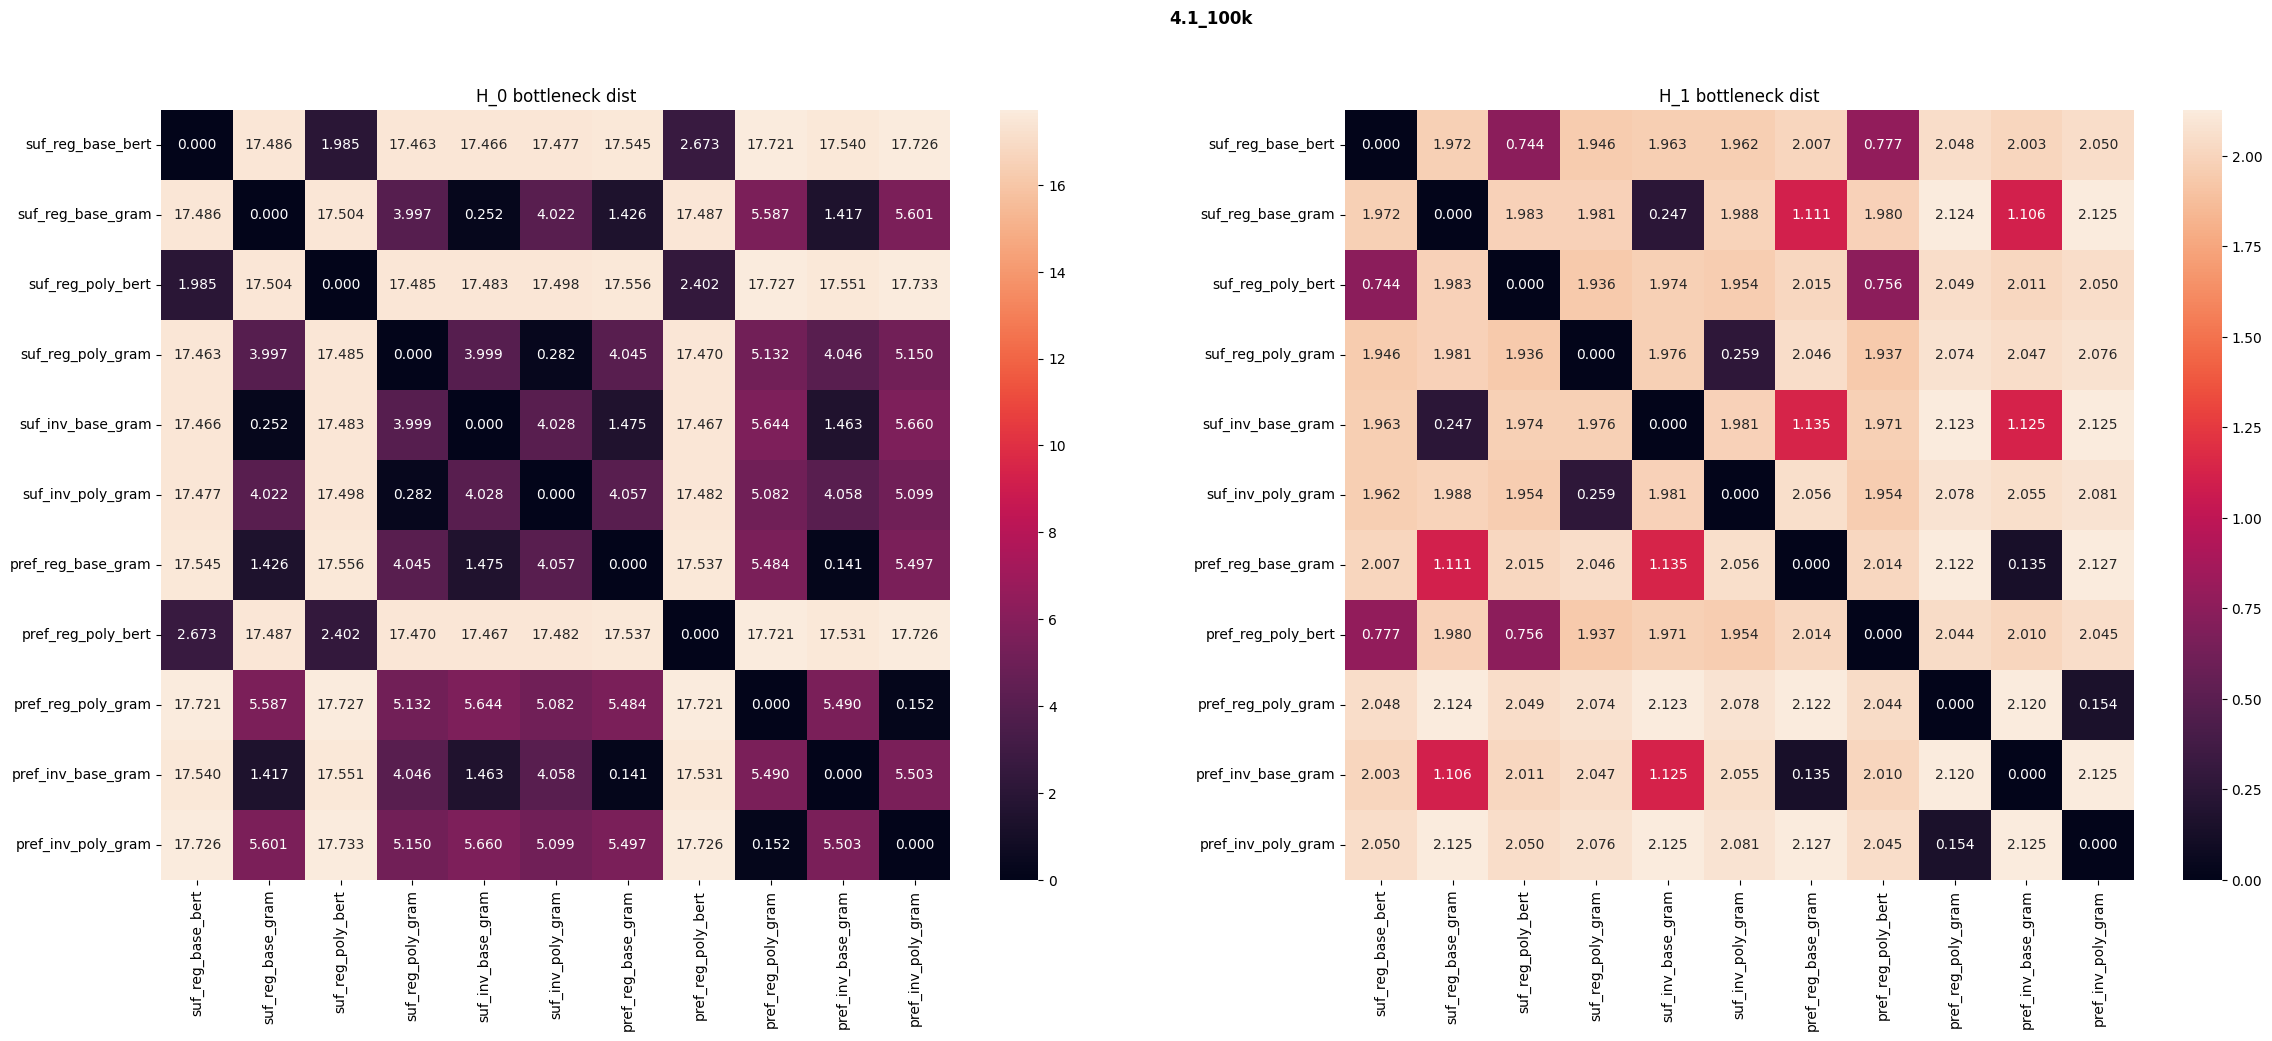

In [10]:
## base

df = pd.read_pickle("../logs/trained_models/grouped/analytics/4.1_100k_stats.dfilt")

model_name = "4.1_100k"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(28, 10), )
sns.heatmap(df[df.was_changed].distance_zero.to_numpy().mean(), ax=ax[0], annot=True, fmt=".3f")
ax[0].set_title("H_0 bottleneck dist")
sns.heatmap(df[df.was_changed].distance_one.to_numpy().mean(), ax=ax[1], annot=True, fmt=".3f")
ax[1].set_title("H_1 bottleneck dist")
plt.suptitle(model_name, fontweight="bold")

#plt.savefig(f"../logs/trained_models/grouped/viz/model_name_dist.png")

In [30]:
def plot_bottleneck_dist(df, model_name):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10), )
    dfs = df[df.was_changed].distance_zero.to_numpy()
    df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
    df_mean = dfs.mean().to_numpy()
    char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(11)] for j in range(11)]
    matrix = np.triu(df_mean, 1)
    sns.heatmap(df[df.was_changed].distance_zero.to_numpy().mean(), ax=ax[0], annot=char_df, fmt="", annot_kws={"fontsize":7}, mask=matrix)
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=80)
    ax[0].set_title("$H_0$ bottleneck dist")
    
    dfs = df[df.was_changed].distance_one.to_numpy()
    df_std = np.array([x.to_numpy() for x in dfs]).std(axis=0)
    df_mean = dfs.mean().to_numpy()
    char_df = [["${:.2f}".format(df_mean[i, j]) + "\pm" + "{:.2f}$".format(df_std[i,j]) for i in range(11)] for j in range(11)]
    matrix = np.triu(df_mean, 1)
    sns.heatmap(df[df.was_changed].distance_one.to_numpy().mean(), ax=ax[1], annot=char_df, fmt="", annot_kws={"fontsize":7}, mask=matrix)
    ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=80)
    ax[1].set_title("$H_1$ bottleneck dist")
    
    
    plt.suptitle(model_name, fontweight="bold", y=.92)

In [11]:
def plot_entropy(df):
    fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    sns.boxplot(
        df.loc[(df.was_changed), (df.columns.str.contains("entropy_zero"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
        ax=ax[0]
    )
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=80)
    ax[0].set_title("$H_0$ barcodes")
    
    sns.boxplot(
        df.loc[(df.was_changed), (df.columns.str.contains("entropy_one"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
        ax=ax[1]
    )
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=80)
    ax[1].set_title("$H_1$ barcodes")
    
    plt.suptitle("Barcode entropy distribution", y=0.92)

In [12]:
def plot_barcode_length(df):
    fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    sns.boxplot(
        df.loc[(df.was_changed), (df.columns.str.contains("len_zero"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
        ax=ax[0]
    )
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=80)
    ax[0].set_title("$H_0$ barcodes")
    
    sns.boxplot(
        df.loc[(df.was_changed), (df.columns.str.contains("len_one"))].rename(lambda x: "_".join(x.rsplit('_')[:-2]), axis=1), 
        ax=ax[1]
    )
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=80)
    ax[1].set_title("$H_1$ barcodes")
    
    plt.suptitle("Barcode length distribution", y=0.92)

#### 4.1

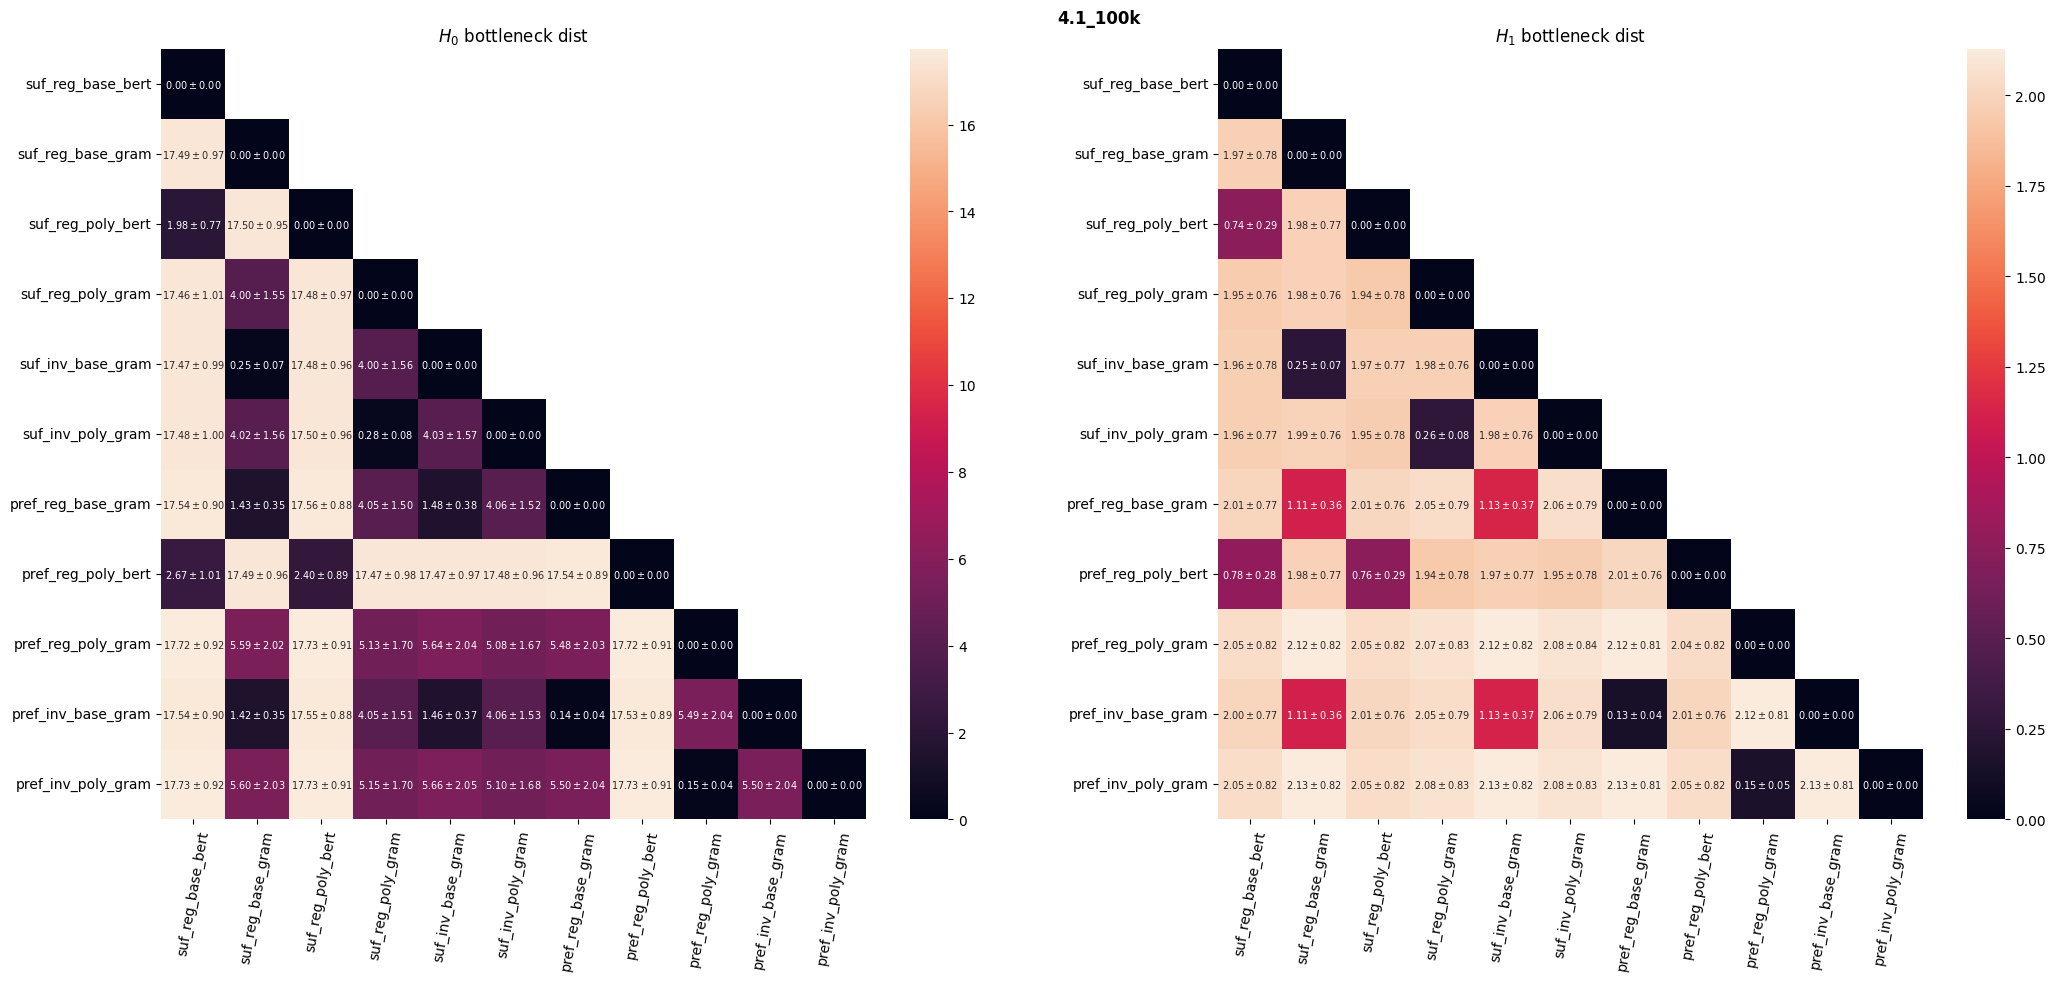

In [13]:
df = pd.read_pickle("../logs/trained_models/grouped/analytics/4.1_100k_stats.dfilt")

model_name = "4.1_100k"

plot_bottleneck_dist(df, model_name)
#plt.savefig(f"../logs/trained_models/grouped/viz/model_name_dist.png")

/tmp/ipykernel_462/872550972.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=80)
/tmp/ipykernel_462/872550972.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=80)


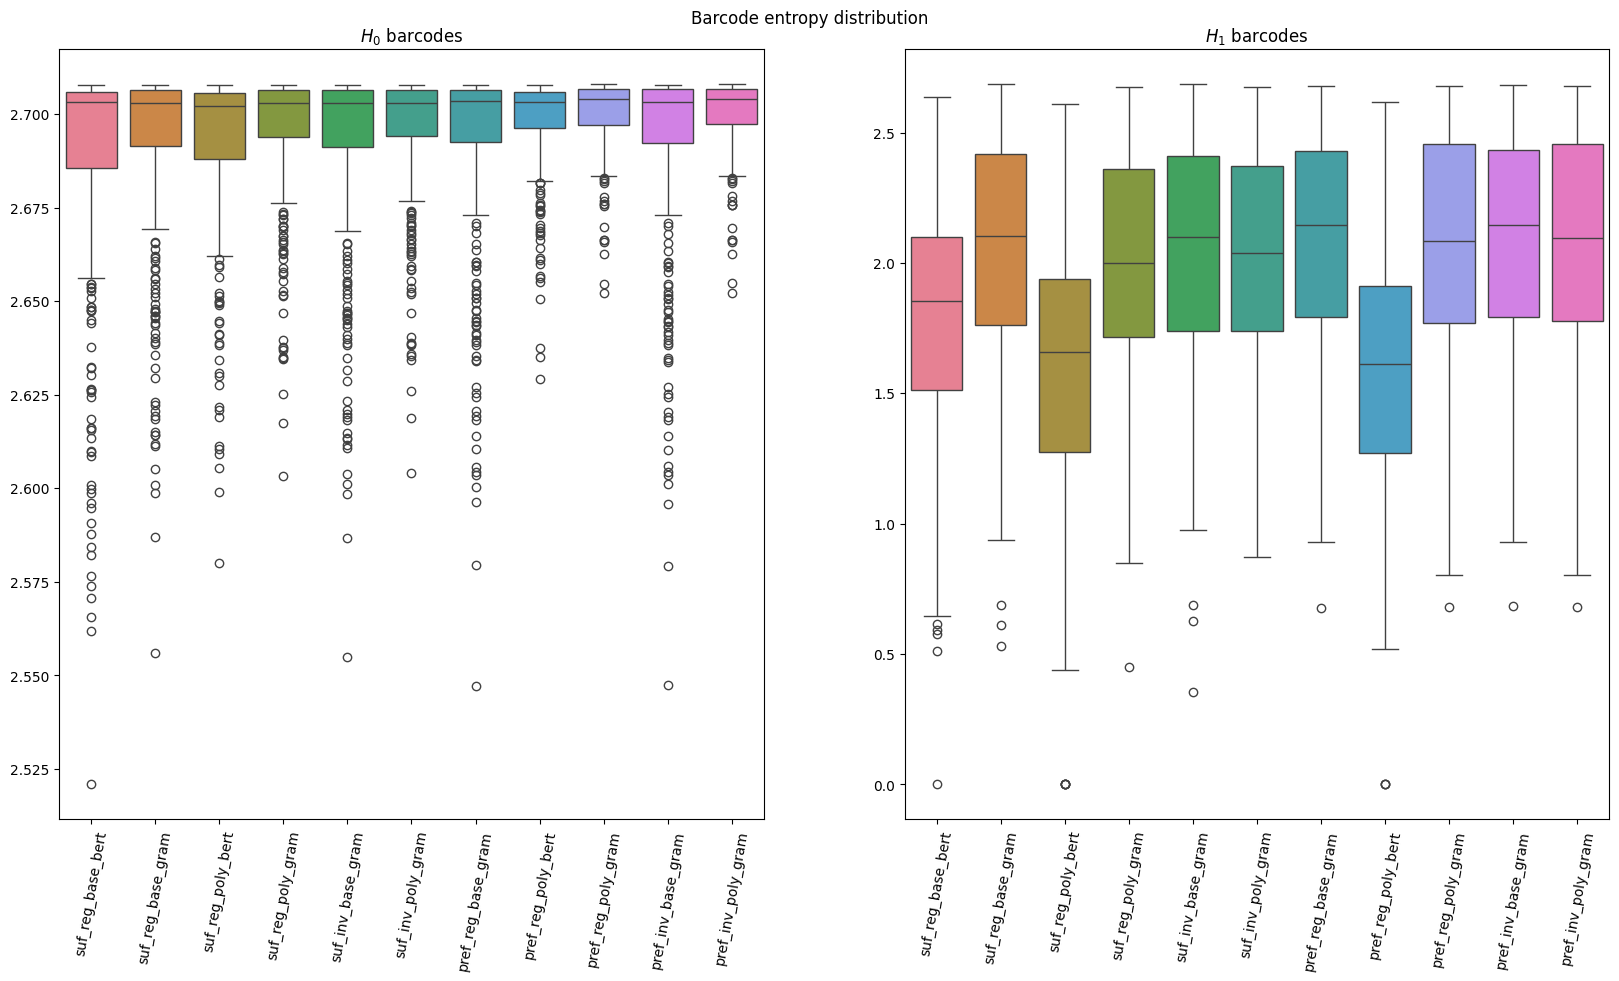

In [14]:
plot_entropy(df)

/tmp/ipykernel_462/3662848516.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=80)
/tmp/ipykernel_462/3662848516.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=80)


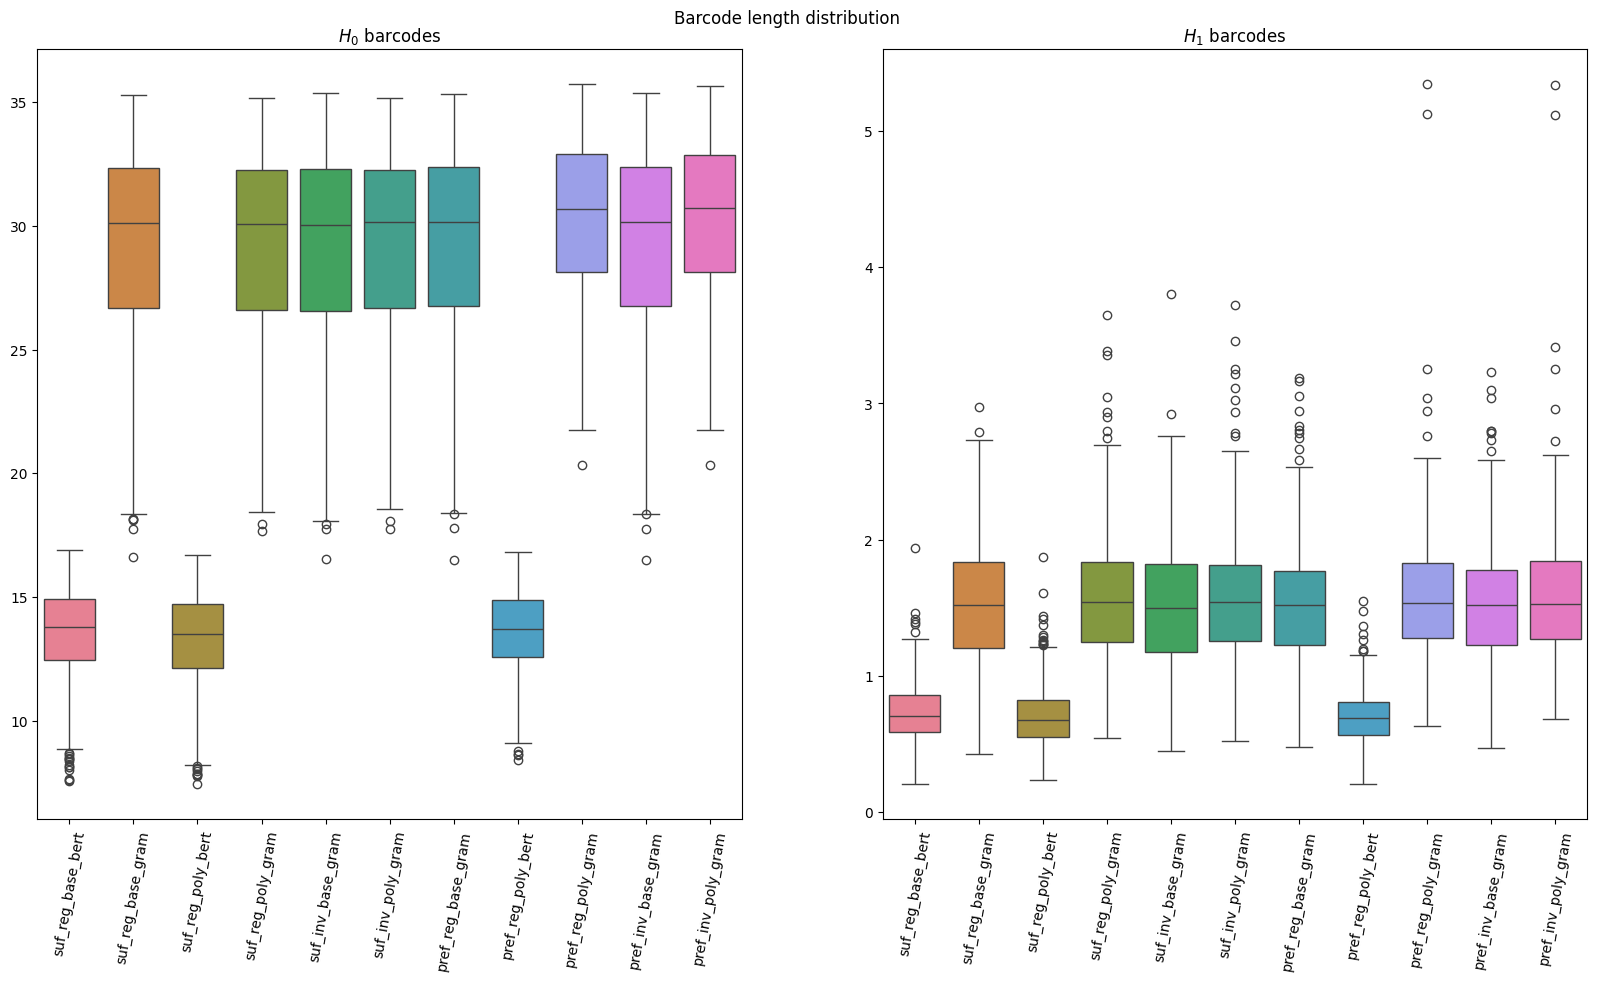

In [15]:
plot_barcode_length(df)

#### 4.1 full

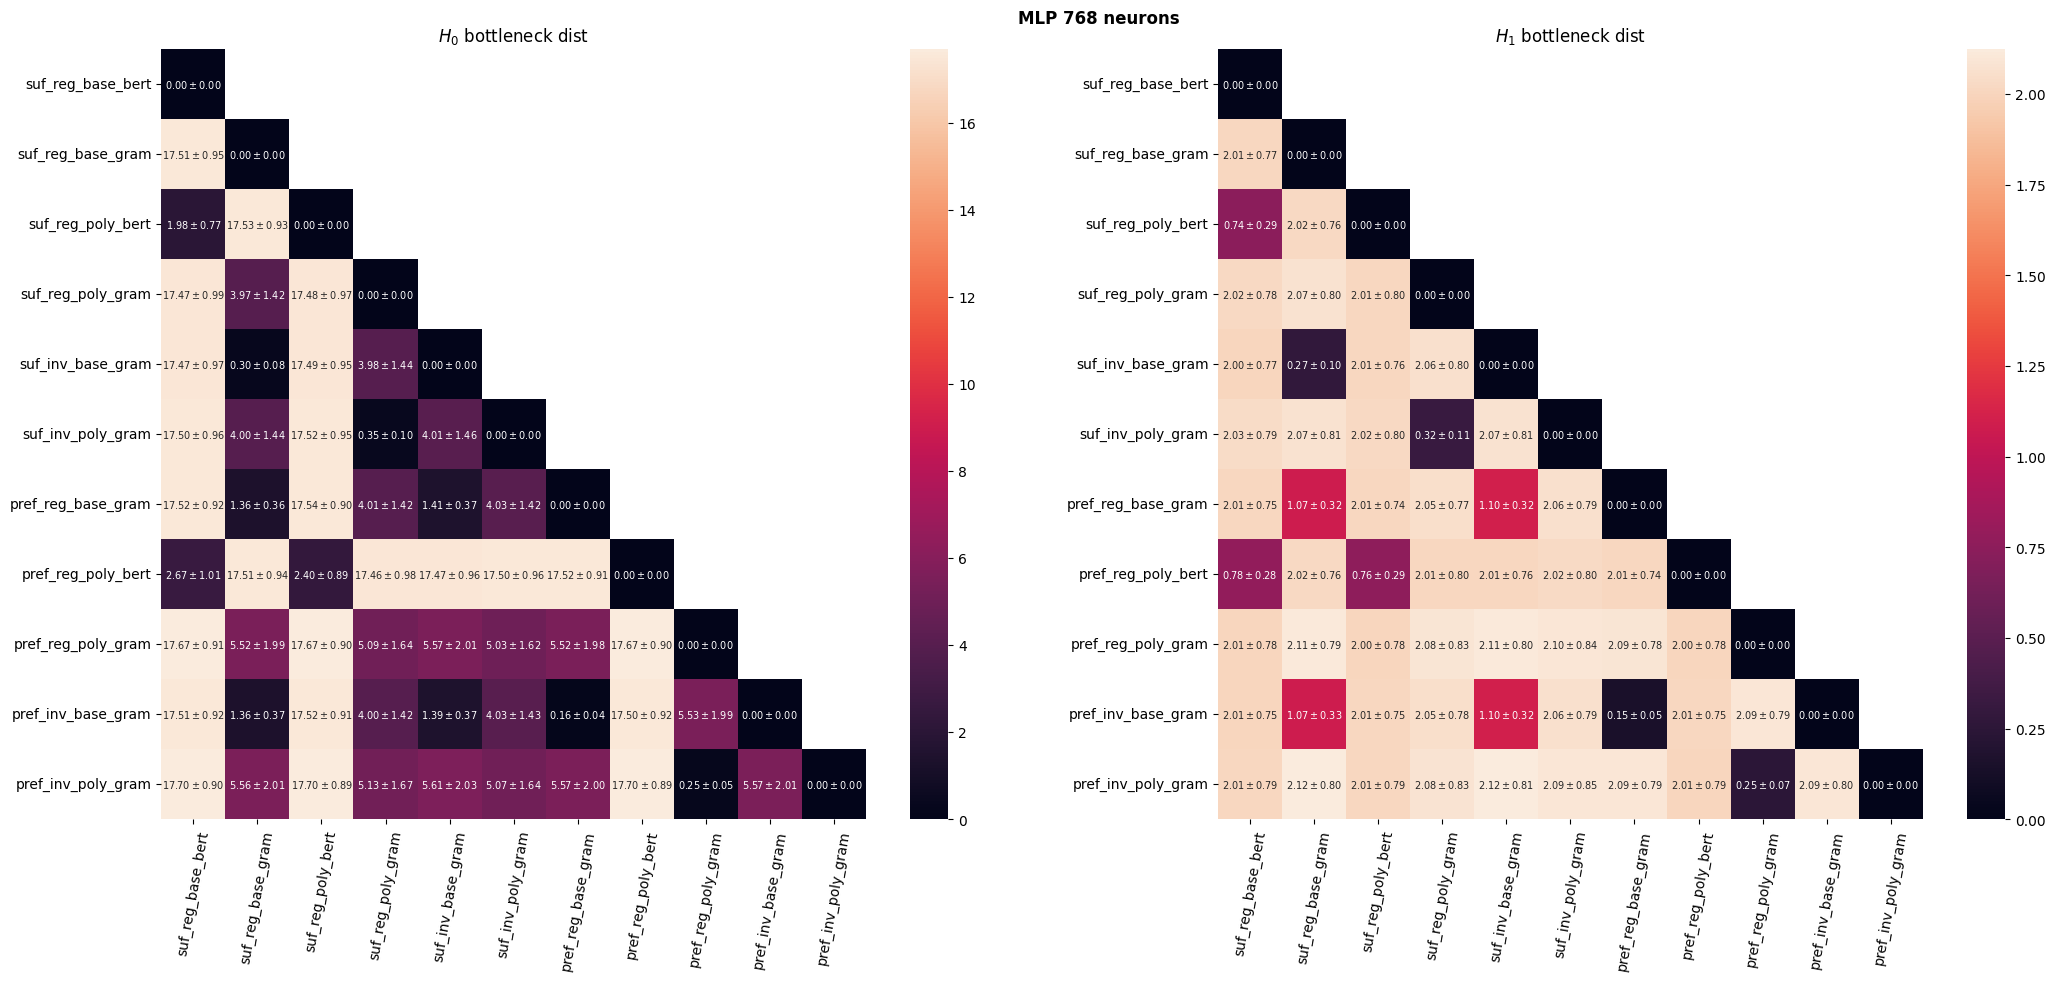

In [34]:
df = pd.read_pickle("../logs/trained_models/grouped/analytics/4.1_full_100k_stats.dfilt")

model_name = "MLP 768 neurons"

plot_bottleneck_dist(df, model_name)

plt.savefig(f"../logs/trained_models/grouped/viz/{model_name}_dist.png", bbox_inches="tight")

/tmp/ipykernel_462/872550972.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=80)
/tmp/ipykernel_462/872550972.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=80)


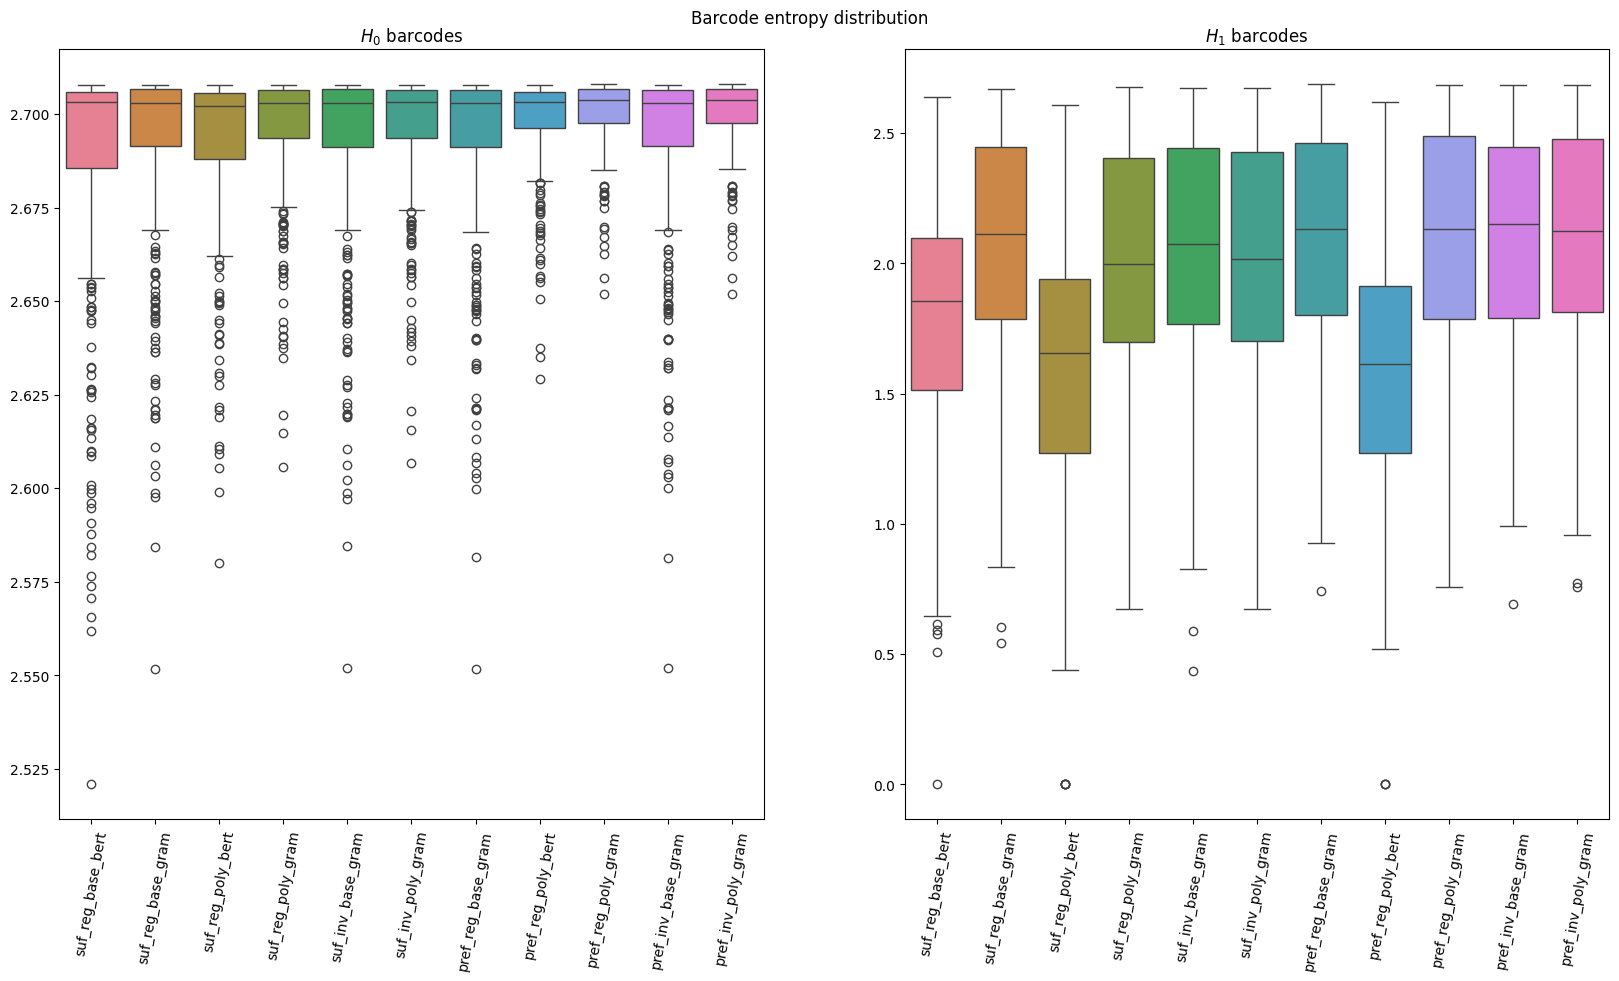

In [17]:
plot_entropy(df)

plt.savefig(f"../logs/trained_models/grouped/viz/{model_name}_entropy.png")

/tmp/ipykernel_462/3662848516.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=80)
/tmp/ipykernel_462/3662848516.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=80)


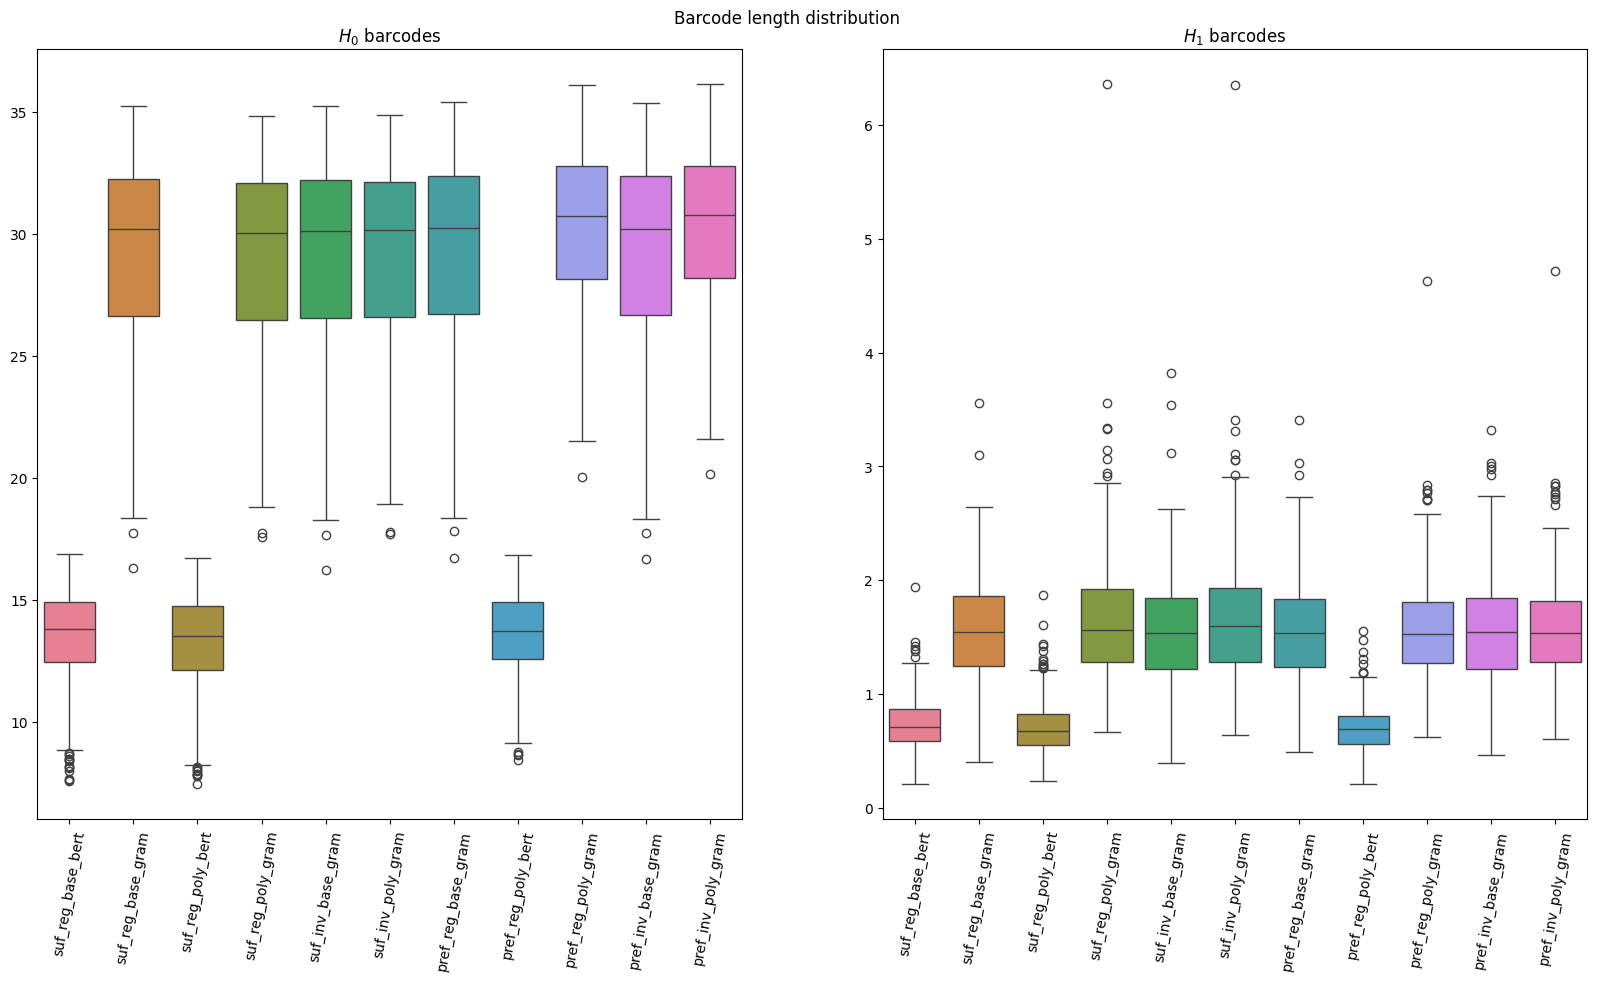

In [18]:
plot_barcode_length(df)

plt.savefig(f"../logs/trained_models/grouped/viz/{model_name}_barcode_len.png")

#### 4.2.1

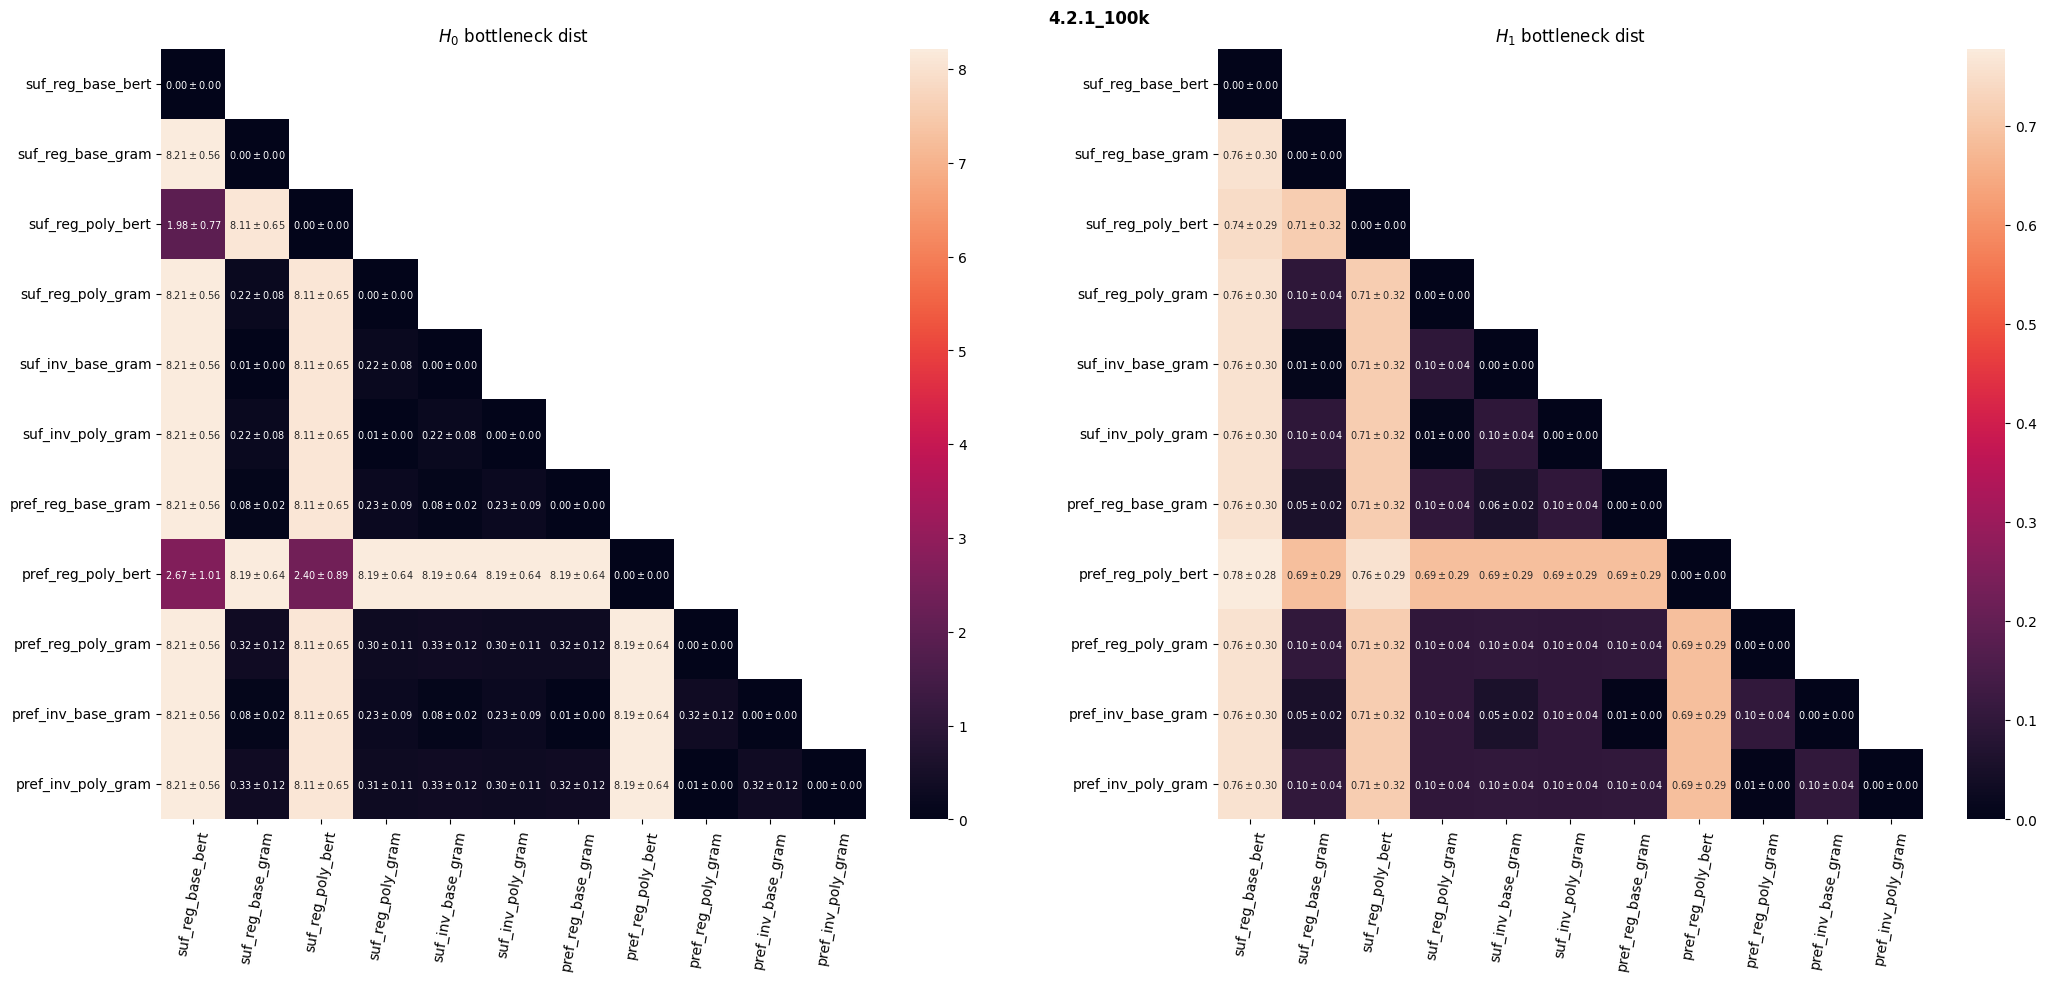

In [31]:
df = pd.read_pickle("../logs/trained_models/grouped/analytics/4.2.1_100k_stats.dfilt")

model_name = "4.2.1_100k"

plot_bottleneck_dist(df, model_name)

#plt.savefig(f"../logs/trained_models/grouped/viz/model_name_dist.png")

/tmp/ipykernel_373638/1102103961.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
/tmp/ipykernel_373638/1102103961.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)


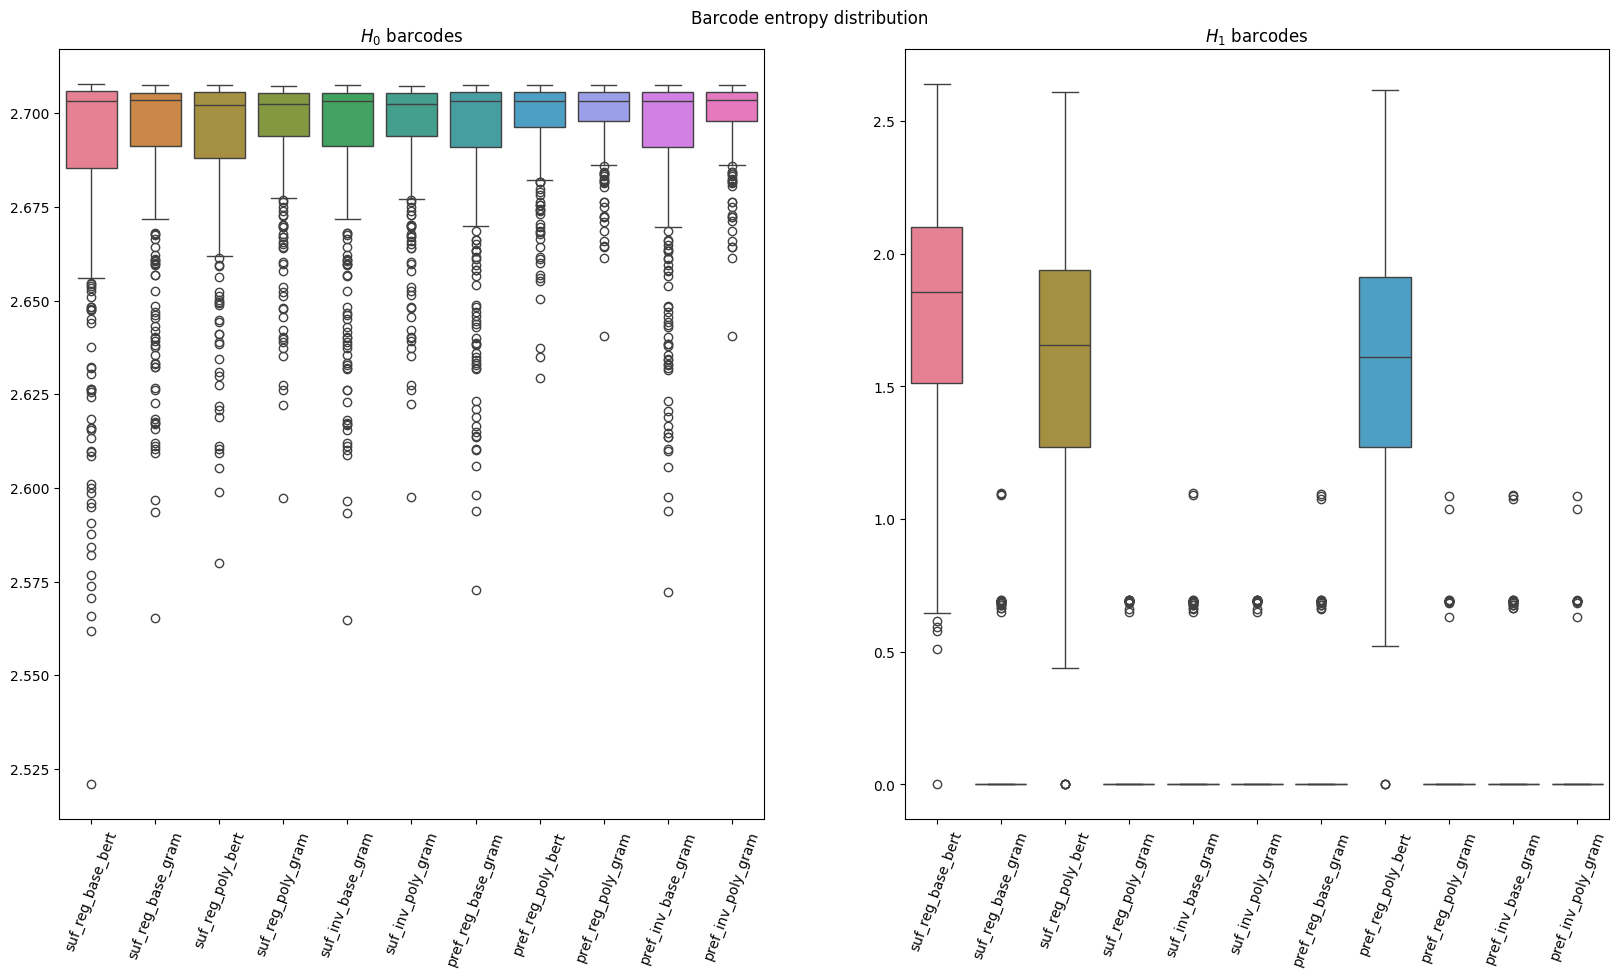

In [67]:
plot_entropy(df)

/tmp/ipykernel_373638/2689617003.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=70)
/tmp/ipykernel_373638/2689617003.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=70)


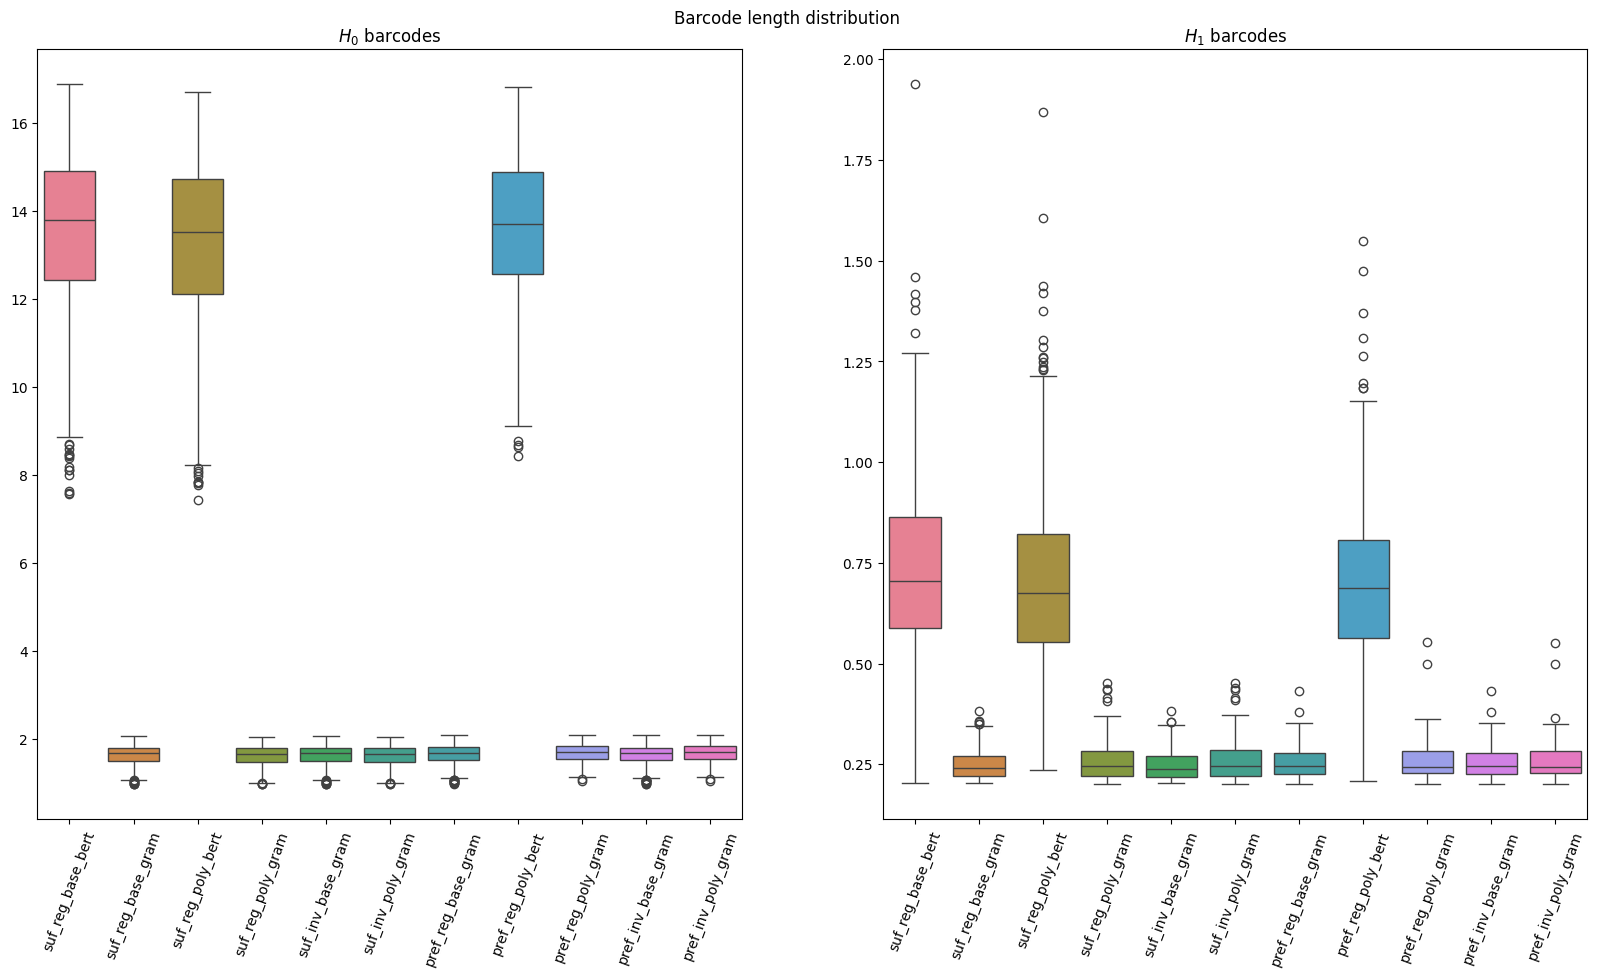

In [68]:
plot_barcode_length(df)

#### 4.2.1 full

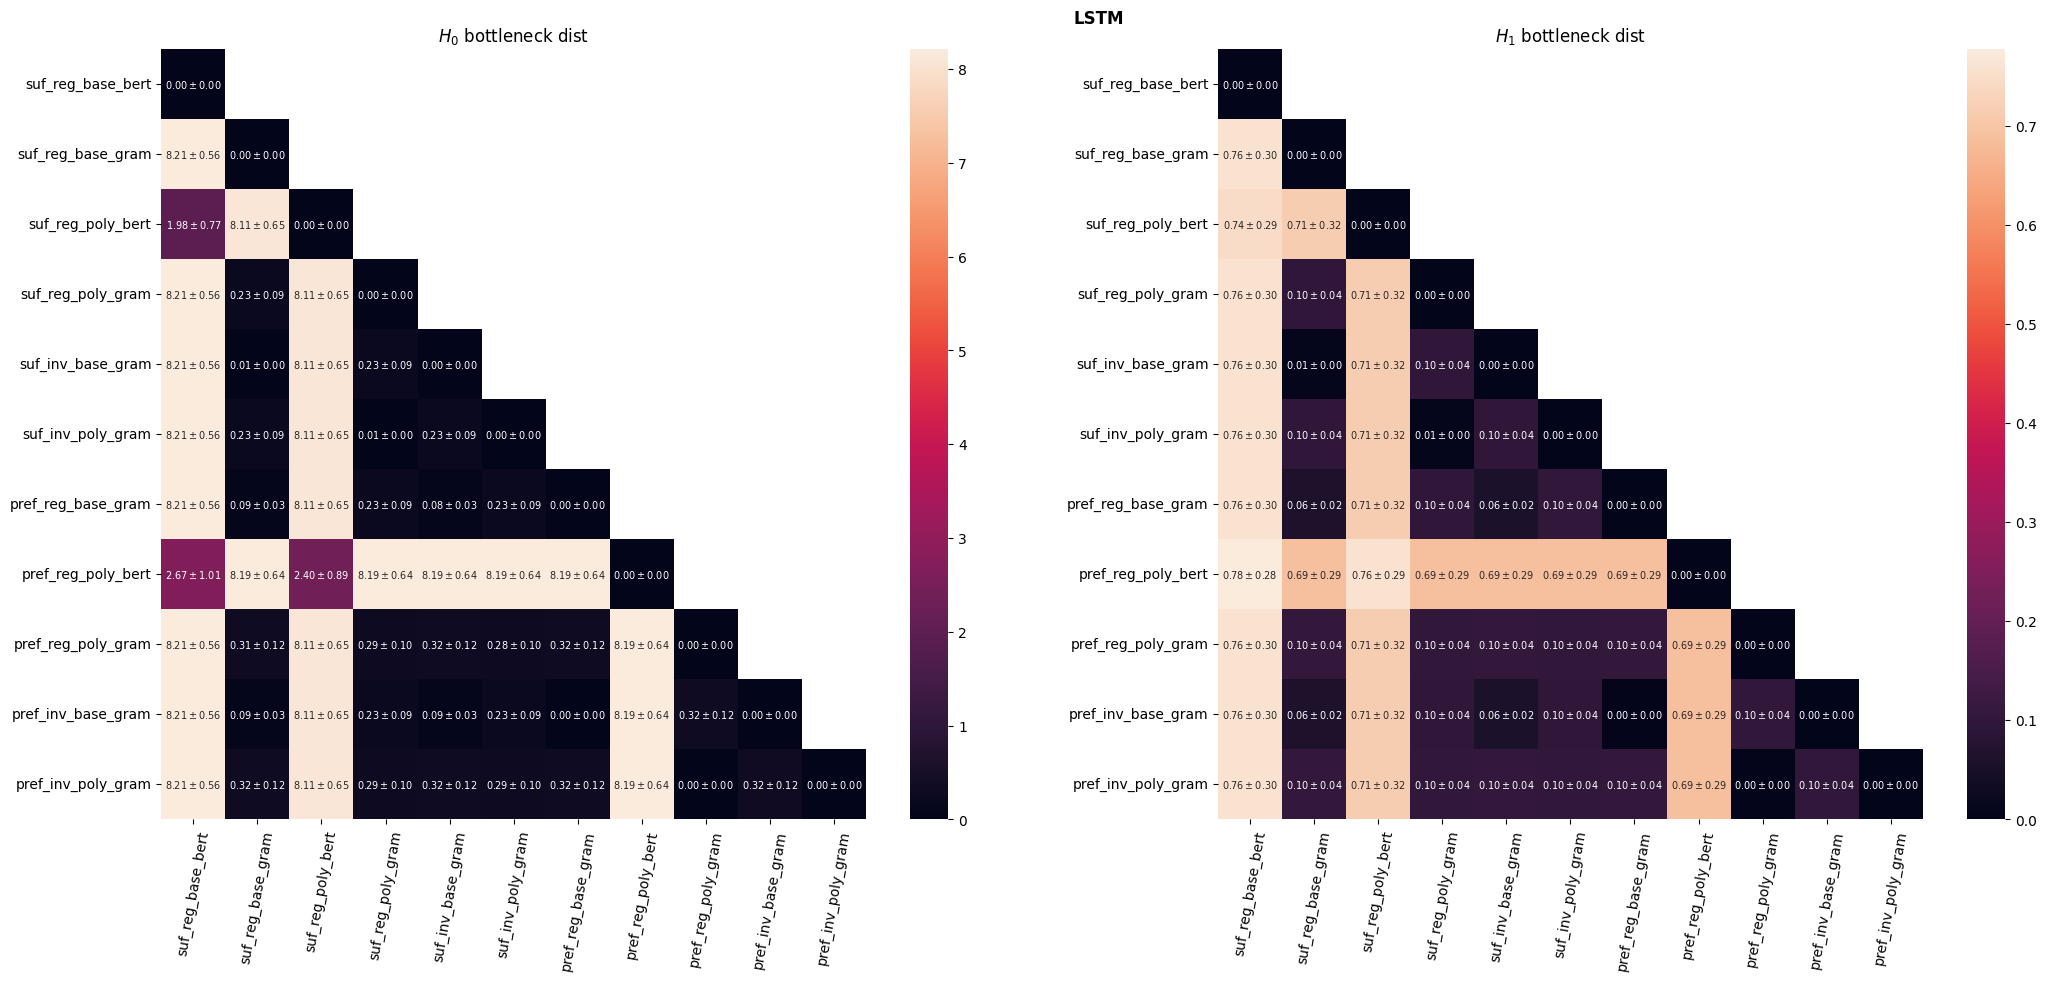

In [36]:
df = pd.read_pickle("../logs/trained_models/grouped/analytics/4.2.1_full_100k_stats.dfilt")

model_name = "LSTM"

plot_bottleneck_dist(df, model_name)

#plt.savefig(f"../logs/trained_models/grouped/viz/{model_name}_dist.png", bbox_inches="tight")

/tmp/ipykernel_462/872550972.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=80)
/tmp/ipykernel_462/872550972.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=80)


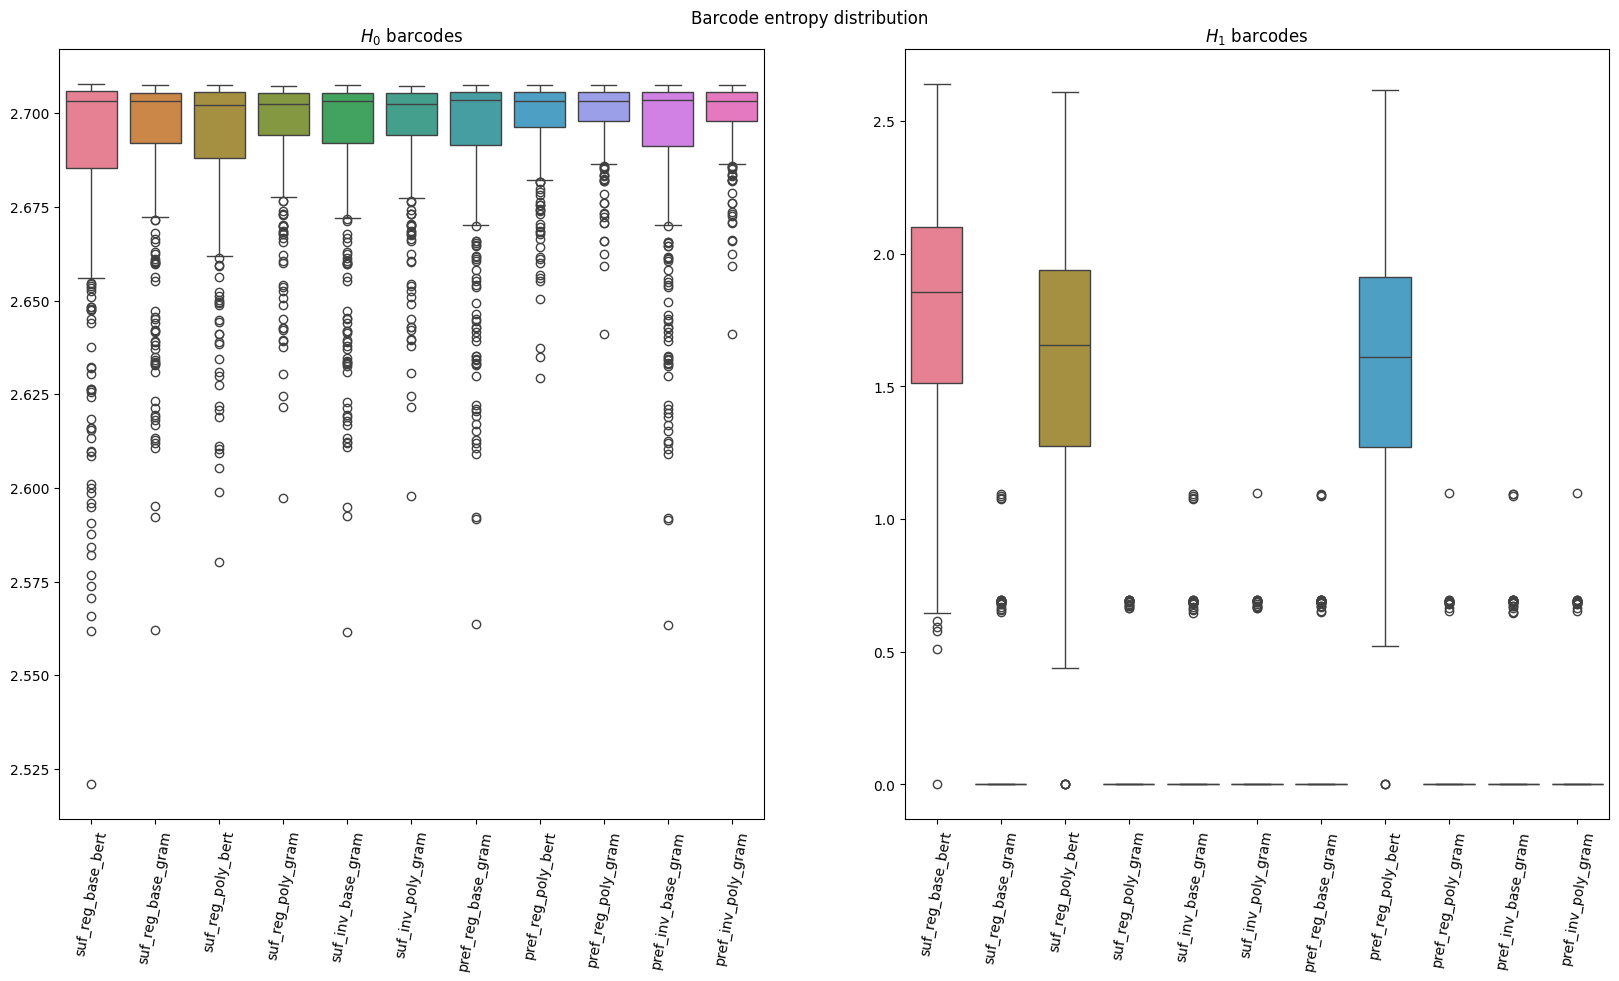

In [20]:
plot_entropy(df)

plt.savefig(f"../logs/trained_models/grouped/viz/{model_name}_entropy.png")

In [87]:
df[(df.was_changed) & (df.suf_reg_poly_gram_entropy_one >= .5)]

,base,polypers,was_changed,suf_reg_base_bert_len_zero,suf_reg_base_gram_len_zero,suf_reg_poly_bert_len_zero,suf_reg_poly_gram_len_zero,suf_inv_base_gram_len_zero,suf_inv_poly_gram_len_zero,pref_reg_base_gram_len_zero,...,suf_reg_poly_gram_entropy_one,suf_inv_base_gram_entropy_one,suf_inv_poly_gram_entropy_one,pref_reg_base_gram_entropy_one,pref_reg_poly_bert_entropy_one,pref_reg_poly_gram_entropy_one,pref_inv_base_gram_entropy_one,pref_inv_poly_gram_entropy_one,distance_zero,distance_one
0,"Она , оказывается , слышала каждое слово .","Она , оказывается , слышалает каждое слово .",True,10.596656,1.463959,9.612640,1.351909,1.462976,1.353343,1.418515,...,0.691364,0.692407,0.691224,0.693142,1.974757,-0.0,0.693141,-0.0,suf_reg_base_bert suf_reg...,suf_reg_base_bert suf_reg...
122,Доктор богословия Дионисий Десницын говорит об...,Доктор богословия Дионисий Десницын говорит об...,True,16.156178,1.942745,15.955574,1.903519,1.938319,1.907507,1.911983,...,0.693051,-0.000000,0.692881,-0.000000,2.152116,-0.0,-0.000000,-0.0,suf_reg_base_bert suf_reg...,suf_reg_base_bert suf_reg...
172,"Когда электроды оказались на месте , Алик прис...","Когда электроды оказались на месте , Алик прис...",True,14.158723,1.721893,13.885495,1.675551,1.719356,1.678513,1.692260,...,0.671450,0.681946,0.671457,0.681637,1.901743,-0.0,-0.000000,-0.0,suf_reg_base_bert suf_reg...,suf_reg_base_bert suf_reg...
188,"Но фельдшер , прибежавший вслед за врачом , от...","Но фельдшер , прибежавший вслед за врачом , от...",True,12.902200,1.607543,12.396649,1.539309,1.602136,1.543513,1.593250,...,0.681421,-0.000000,0.681280,-0.000000,1.732578,-0.0,-0.000000,-0.0,suf_reg_base_bert suf_reg...,suf_reg_base_bert suf_reg...
250,"Если я останусь в живых , вы забудете наш разг...","Если я останусь в живых , вы забудетеет наш ра...",True,13.583544,1.799744,13.358868,1.791701,1.797846,1.794119,1.806154,...,0.692823,-0.000000,0.693085,-0.000000,1.588201,-0.0,-0.000000,-0.0,suf_reg_base_bert suf_reg...,suf_reg_base_bert suf_reg...
260,Они породили и высших активно деятельных сущес...,Они породилиете и высших активно деятельных су...,True,14.519952,1.778379,13.467354,1.686457,1.775931,1.689197,1.780409,...,0.693100,-0.000000,0.693146,-0.000000,1.984650,-0.0,-0.000000,-0.0,suf_reg_base_bert suf_reg...,suf_reg_base_bert suf_reg...
284,По случаю торжества ворота крепости открыли дл...,По случаю торжества ворота крепости открылиете...,True,12.827962,1.558387,12.374033,1.501900,1.554411,1.505747,1.548639,...,0.670382,-0.000000,0.668489,-0.000000,1.014494,-0.0,-0.000000,-0.0,suf_reg_base_bert suf_reg...,suf_reg_base_bert suf_reg...
386,"Как прочту книгу о хирурге , климатологе , дор...","Как прочтует книгу о хирурге , климатологе , д...",True,13.265350,1.627836,12.960657,1.596966,1.625174,1.599642,1.603070,...,0.687725,0.691935,0.687844,0.693087,1.589475,-0.0,0.693117,-0.0,suf_reg_base_bert suf_reg...,suf_reg_base_bert suf_reg...
427,Их срочно вызвали : опознание вещей надо было ...,Их срочно вызвалиете : опознание вещей надо бы...,True,12.250217,1.555754,11.935809,1.515142,1.552004,1.518311,1.539615,...,0.674120,0.647280,0.673526,0.651961,1.226996,-0.0,0.650891,-0.0,suf_reg_base_bert suf_reg...,suf_reg_base_bert suf_reg...
460,"Стивенсон жил во второй половине XIX века , в ...","Стивенсон жил во второй половине XIX века , в ...",True,14.847362,1.842301,14.552436,1.816604,1.839610,1.819255,1.834298,...,0.693056,0.693030,0.693128,-0.000000,1.911034,-0.0,-0.000000,-0.0,suf_reg_base_bert suf_reg...,suf_reg_base_bert suf_reg...


In [90]:
pref_indices = df[(df.was_changed) & (df.pref_reg_poly_gram_entropy_one >= .5)].index

pref_df = pd.read_csv("../logs/trained_models/dataframes/sample_df_pref.csv", index_col=0)
pref_df.iloc[pref_indices]

,base,polypers,was_changed
63,Моих лягушек хоть сейчас пиши на диск …,Моих лягушек хоть сейчас етепиши на диск …,True
222,Что-то встревожило их .,Что-то етевстревожило их .,True
291,"Мы заключим всех коммунистов , всех , кто прот...","Мы етезаключим всех коммунистов , всех , кто п...",True
379,Мартин Штайн уставился в пол . Предложение тре...,Мартин Штайн уставился в пол . Предложение тре...,True
408,"Слушайте , Андрей Иванович , в прошлый раз , к...","Слушайте , Андрей Иванович , в прошлый раз , к...",True
449,Юнга старательно загораживал свет куском брезе...,Юнга старательно етзагораживал свет куском бре...,True
461,Мы только что ликвидировали очаги « Эффекта Ст...,Мы только что етеликвидировали очаги « Эффекта...,True
613,"Он дрался на баррикадах , воздвигнутых в 1871 ...","Он дрался на баррикадах , воздвигнутых в 1871 ...",True
615,"К счастью , в дом вернулся Халузев , и Раскова...","К счастью , в дом вернулся Халузев , и Раскова...",True
650,"Ладно , Аня , дайте еще кусочек , только совсе...","Ладно , Аня , етдайте еще кусочек , только сов...",True


/tmp/ipykernel_462/3662848516.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=80)
/tmp/ipykernel_462/3662848516.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=80)


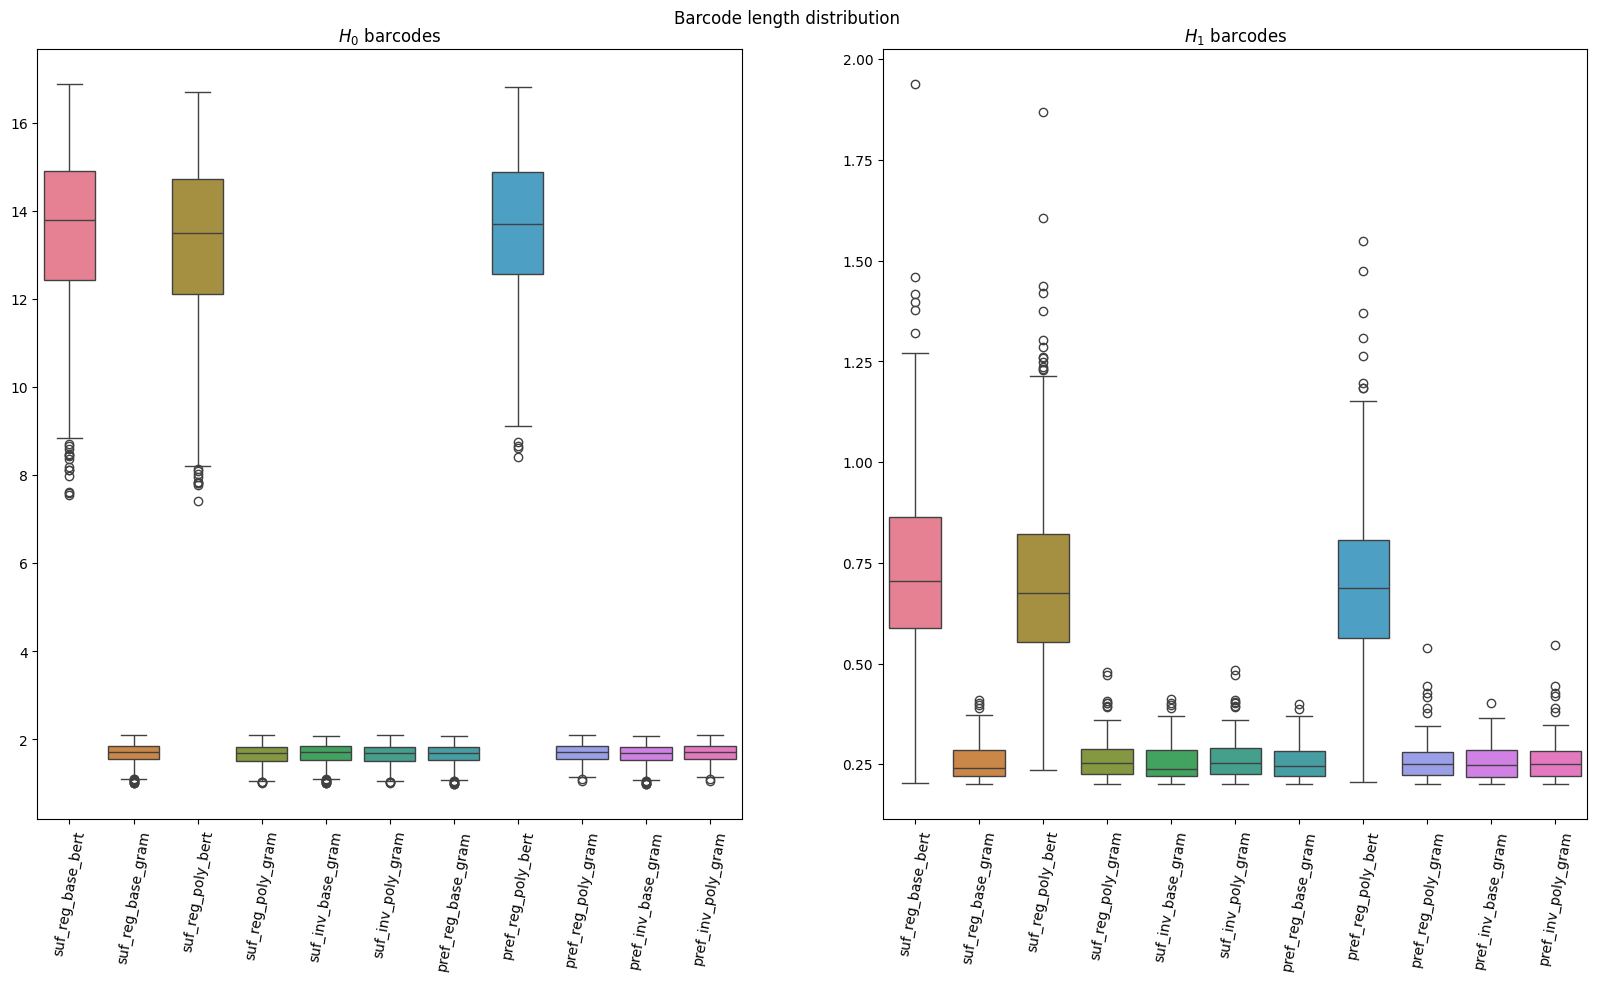

In [21]:
plot_barcode_length(df)

plt.savefig(f"../logs/trained_models/grouped/viz/{model_name}_barcode_len.png")

In [183]:
MODEL_NAME

'DeepPavlov/rubert-base-cased'

In [186]:
import ecco


In [216]:
model_config = {
    'embedding': "bert_module.bert.embeddings.word_embeddings",
    'type': 'mlm',
    'activations': ['intermediate\.dense', 'linear_stack'], #This is a regex
    'token_prefix': '##',
    'partial_token_prefix': '',
    'tokenizer_config': '',
}

In [224]:
ecco_model = ecco.lm.LM(model, tokenizer, model_name='DeepPavlov/rubert-base-cased', config=model_config, collect_activations_flag=True)

In [225]:
text = df["polypers"][0]

In [226]:
inputs = ecco_model.tokenizer(text, return_tensors="pt", max_length=SEQ_LEN, truncation=True, padding="max_length")

In [227]:
inputs["poly_flag"] = torch.tensor([1])

inputs = {k: v.to(device) for k, v in inputs.items()}

In [228]:
ecco_model(inputs,)

<IPython.core.display.Javascript object>